<div id= 'main'>
    <h1><p style= 'text-align:center;'>Time Series Modeling & Forecasting</p></h1>
</div>

<br>
<h2>AutoCorrelation Functions</h2>

    - AutoCorrelation function (ACF)
    - Partial AutoCorrelation function (PACF)
<br>

In [177]:
ice_df = pd.read_csv( 'datasets/ice_cream.csv' )

ice_df.rename( columns= { 'DATE':'date', 'IPN31152N': 'production_amt' }, inplace= True  )

ice_df = ice_df.set_index( pd.to_datetime(ice_df['date']) )

ice_df.drop( 'date', axis= 1, inplace= True )

ice_df= ice_df[ '2010-01-01': ]

ice_df

production_amt
date                      
2010-01-01         91.2895
2010-02-01        110.4994
2010-03-01        127.0971
...                    ...
2019-11-01         79.7223
2019-12-01         75.7094
2020-01-01         83.6290

[121 rows x 1 columns]

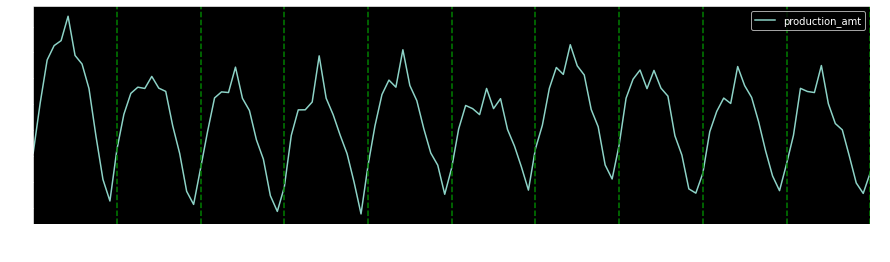

In [179]:
ax = ice_df.plot( figsize= (15,4) )

[ ax.axvline( x= pd.to_datetime(str(e_yr)+'-01-01'), color= 'green', linestyle= '--' )\
  for e_yr in range(2011,2021)                                                            ];

#### ACF & PACF

In [180]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import ( MultipleLocator, AutoMinorLocator )

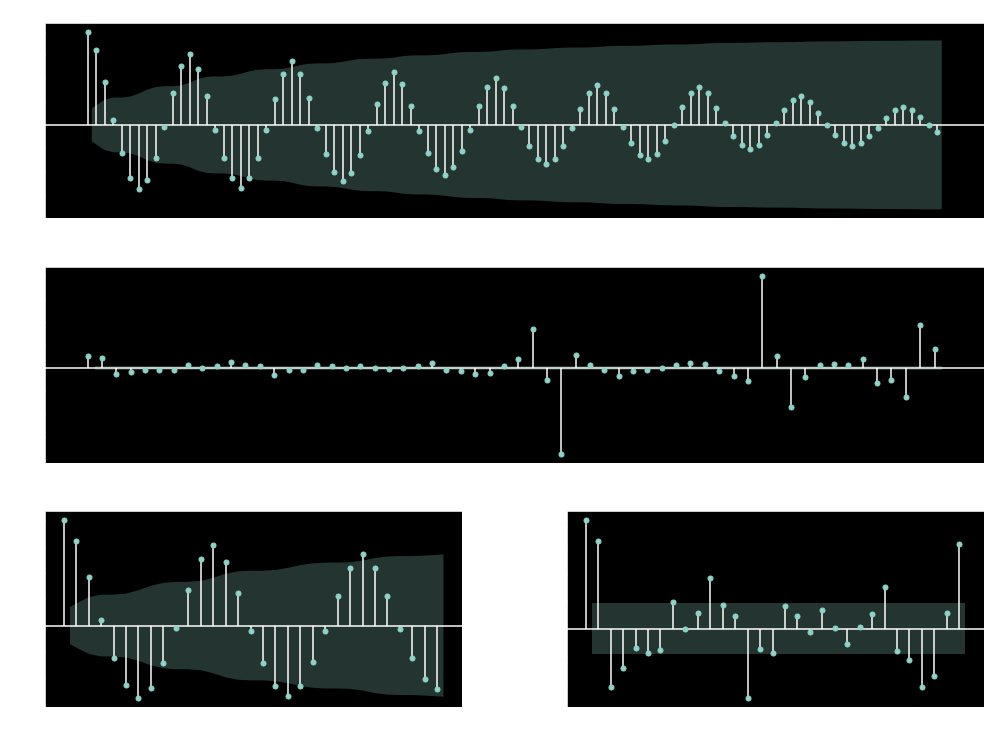

In [182]:
# fg, ax = plt.subplots( 4,2, figsize= (18,10) )

fg = plt.figure()

gs = GridSpec( 3,2, figure= fg, top= 2.5, right= 2.3, hspace= 0.25, wspace= 0.25  )

ax1 = fg.add_subplot( gs[0,:] )
plot_acf( x= ice_df.production_amt, lags= 100, ax= ax1 )
set_Xticks( ax1, minor_major= (1,5) )

ax2 = fg.add_subplot( gs[1,:] )
plot_pacf( x= ice_df.production_amt, lags= 59, ax= ax2, alpha= 0.05 )

ax3a = fg.add_subplot( gs[2,0] )
plot_acf( x= ice_df.production_amt, lags= 30, ax= ax3a )

ax3b = fg.add_subplot( gs[2,1] )
plot_pacf( x= ice_df.production_amt, lags= 30, alpha= 0.01, ax= ax3b, )

set_Xticks_for_axes( ax_ls= [ax1,ax2,ax3a,ax3b], minor_major= (1,5)  )

plt.tight_layout()

Based on the `PACF`, we could start with `AR` model with lag 1, 2, 3, 13, 30

#### get stock data from Yahoo

In [183]:
# get data from yahoo
tckr_symb = 'SPY'
tckrData = yf.Ticker( tckr_symb )
spy_df = tckrData.history( period= '1d', start= '2015-1-1', end= '2020-1-1' )

spy_df = spy_df[['Close']]

# 1st difference
spy_df['diff_1'] = spy_df.diff()
print( spy_df )


                 Close    diff_1
Date                            
2015-01-02  182.149979       NaN
2015-01-05  178.860443 -3.289536
2015-01-06  177.175781 -1.684662
...                ...       ...
2019-12-27  315.906494 -0.078308
2019-12-30  314.164856 -1.741638
2019-12-31  314.928040  0.763184

[1258 rows x 2 columns]


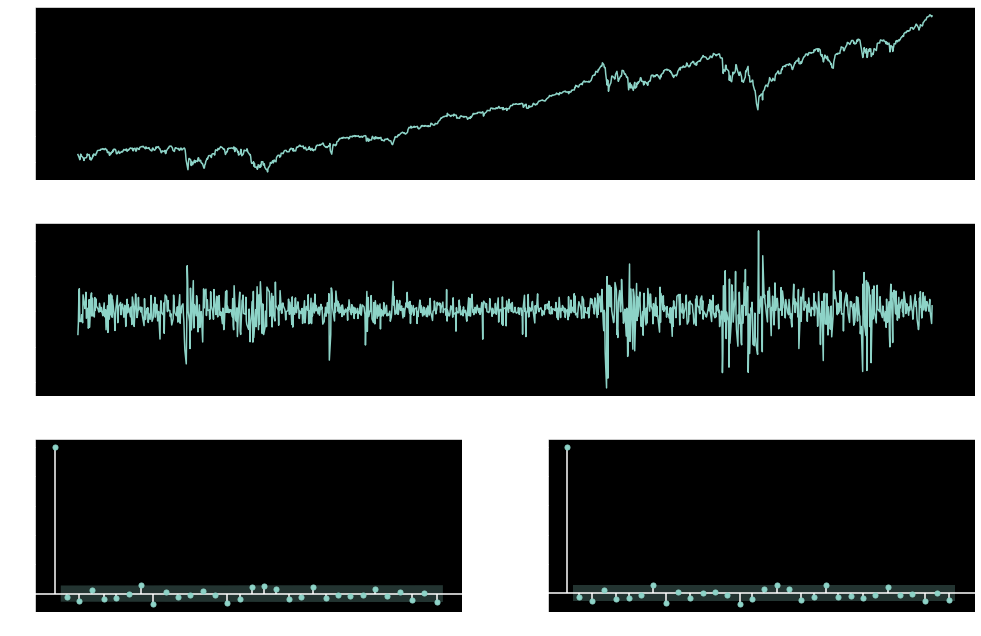

In [184]:
fg = plt.figure()
gs = GridSpec( 3,2, figure= fg, top= 2.3, right= 2.3, hspace= 0.25, wspace= 0.2 )

ax1 = fg.add_subplot( gs[0,:] )
spy_df['Close'].plot( ax= ax1 )

ax2 = fg.add_subplot( gs[1,:] )
spy_df['diff_1'].plot( ax= ax2 )

ax3a = fg.add_subplot( gs[2,0] )
plot_acf( x= spy_df['diff_1'].dropna(), ax= ax3a )

ax3b = fg.add_subplot( gs[2,1] )
plot_pacf( x= spy_df['diff_1'].dropna(), ax= ax3b )

set_Xticks_for_axes( ax_ls= [ax3a,ax3b], minor_major= (1,5) )

plt.tight_layout()

`ACF` & `PACF` aren't informative. This is an reason why stock prediction is very difficult.

<br>


##   `AR` model


### `AR` Model: &emsp; ${y}_t$  &thinsp; =  &thinsp; $\mu$  &thinsp; +  &thinsp; $\phi_{1 }$ &thinsp; $y_{t-1}$  &thinsp; +  &thinsp; $\phi_{2}$  &thinsp; $y_{t-2}$  &thinsp; +  &thinsp; $\phi_{3}$  &thinsp; $y_{t-3}$

In [21]:
ice_df = pd.read_csv( 'datasets/ice_cream.csv', parse_dates= ['DATE'], index_col= 'DATE' )

ice_df.columns = [ 'production_amt' ]

ice_df= ice_df[ '2010-01-01': ]
ice_df

production_amt
DATE                      
2010-01-01         91.2895
2010-02-01        110.4994
2010-03-01        127.0971
...                    ...
2019-11-01         79.7223
2019-12-01         75.7094
2020-01-01         83.6290

[121 rows x 1 columns]

In [397]:
# Train-test set

train_endDt = datetime.datetime( 2016,12,1 )
test_endDt  = datetime.datetime( 2019,12,1 )

ice_Train_df = ice_df[ :train_endDt ]
ice_Test_df = ice_df[ train_endDt + datetime.timedelta(days=1) : test_endDt ]

In [186]:
# fitting model

armaModel_fit = ARMA( ice_Train_df, order= (3,0) ).fit()
print( armaModel_fit.summary() )

                              ARMA Model Results                              
Dep. Variable:         production_amt   No. Observations:                   84
Model:                     ARMA(3, 0)   Log Likelihood                -294.008
Method:                       css-mle   S.D. of innovations              7.903
Date:                Wed, 19 May 2021   AIC                            598.015
Time:                        21:06:12   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  103.5080      2.176     47.575      0.000      99.244     107.772
ar.L1.production_amt     1.0488      0.099     10.573      0.000       0.854       1.243
ar.L2.produc

c:\python-projects\machine-learning\lib\site-packages\ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


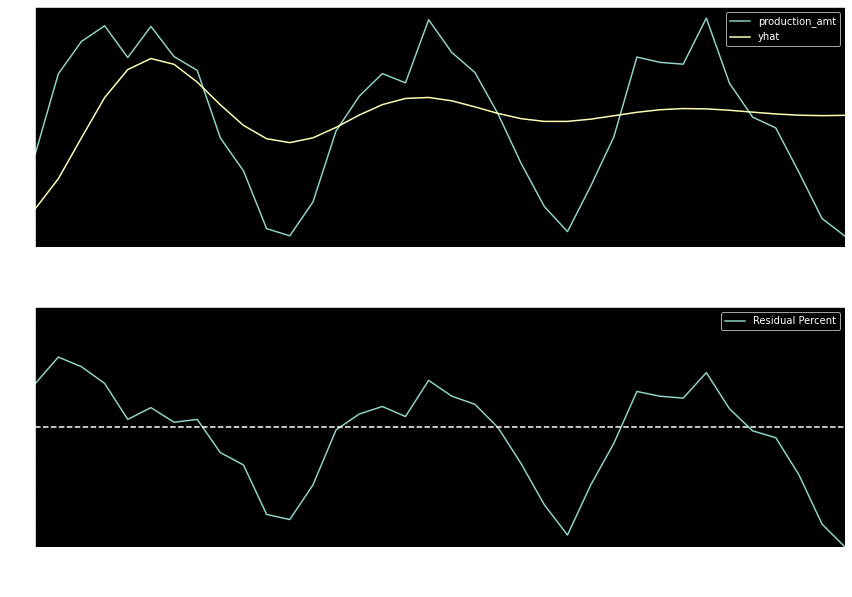

In [83]:
# prediction & residual
yhat = armaModel_fit.predict( start= ice_Test_df.index[0], end= ice_Test_df.index[-1] )
yi_yhat = ice_Test_df['production_amt'] - yhat

yi_yhat_percent = yi_yhat/ice_Test_df['production_amt'] * 100

# plots

fg = plt.figure()
gs = GridSpec( 2,2, figure= fg, top= 2, right= 2, hspace= 0.25, wspace= 0.2 )

ax1 = fg.add_subplot( gs[0,:] )
ice_Test_df.plot( ax= ax1 );    yhat.plot( ax= ax1, label= 'yhat' )
ax1.legend()

ax2 = fg.add_subplot( gs[1,:] )
yi_yhat_percent.plot( ax= ax2, label= 'Residual Percent' )
ax2.axhline( y= 0, linestyle= '--' )
ax2.set_ylim( bottom=  -max( abs(min(yi_yhat_percent)), abs(max(yi_yhat_percent)) ),
              top=      max( abs(min(yi_yhat_percent)), abs(max(yi_yhat_percent)) ) )
ax2.legend()

plt.tight_layout()

In [87]:
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_percent)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat**2)),2) } ' )

Mean Absolute % Error = 12.11
Root mean Squared error = 13.89 


<br>

### Rolling Forecast Origin
<br>

#### Predict one month in advance each time

    Train on months 1, 2, 3, ... , k - 10                                      -->   predict month k - 9
    Train on months 1, 2, 3, ... , k - 10, k - 9                               -->   predict month k - 8
    Train on months 1, 2, 3, ... , k - 10, k - 9, k - 8                        -->   predict month k - 7
    
    ...                ...                ...                ...                  ...                ...
    
    Train on months 1, 2, 3, ... , k - 10, k - 9, k - 8, ... , k - 2, k - 1    -->   predict month k
    
    Average all predictions   

In [398]:
warnings.filterwarnings( action= 'ignore' )

yhat_roll = pd.Series( dtype= float )

for e_endDt in ice_Test_df.index:
    ice_Train_df = ice_df[ : e_endDt - datetime.timedelta(days=1) ]
    armaModel_fit = ARMA( ice_Train_df, order= (3,0) ).fit()
    yhat = armaModel_fit.predict(e_endDt)
    yhat_roll.loc[e_endDt] = yhat.loc[e_endDt]
    
yi_yhat_Roll = ice_Test_df['production_amt'] - yhat_roll

yi_yhat_Roll_percent = ( ice_Test_df['production_amt'] - yhat_roll )/ ice_Test_df['production_amt'] * 100

# model stats
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_Roll_percent/100)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat_Roll**2)),2) } ' )

Mean Absolute % Error = 0.06
Root mean Squared error = 7.2 


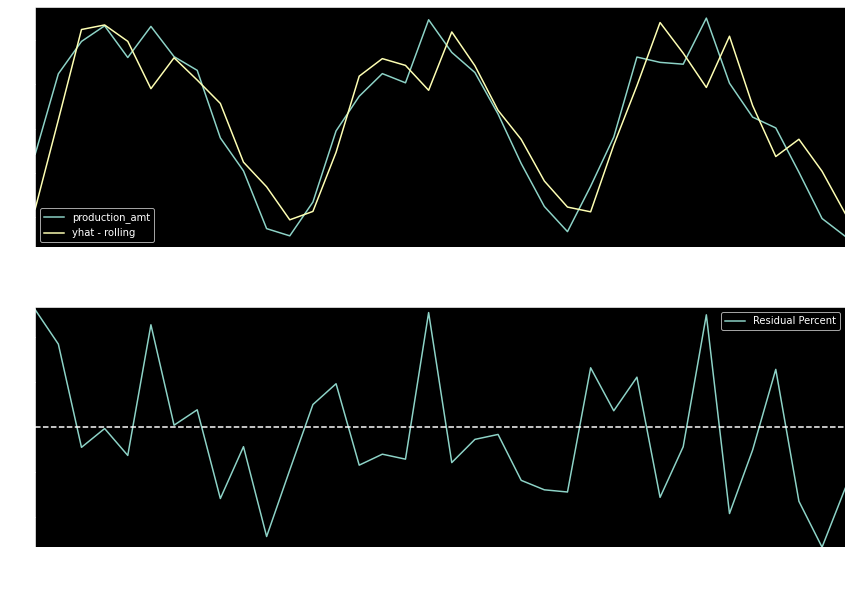

In [399]:
# plots

fg = plt.figure()
gs = GridSpec( 2,2, figure= fg, top= 2, right= 2, hspace= 0.25, wspace= 0.2 )

ax1 = fg.add_subplot( gs[0,:] )
ice_Test_df.plot( ax= ax1 );    yhat_roll.plot( ax= ax1, label= 'yhat_rolling' )
ax1.legend()

ax2 = fg.add_subplot( gs[1,:] )
yi_yhat_Roll_percent.plot( ax= ax2, label= 'Residual Percent' )
ax2.axhline( y= 0, linestyle= '--' )
ax2.set_ylim( bottom=  -max( abs(min(yi_yhat_Roll_percent)), abs(max(yi_yhat_Roll_percent)) ),
              top=      max( abs(min(yi_yhat_Roll_percent)), abs(max(yi_yhat_Roll_percent)) ) )
ax2.legend()

plt.tight_layout()

#### AR Model

In [227]:
# using date parser udf

def dt_parser_func(strng):
    return( datetime.datetime.strptime( strng, '%Y-%m-%d' ) )

In [228]:
ice_Ser = pd.read_csv( 'datasets/ice_cream.csv', parse_dates= [0], index_col= 0, date_parser= dt_parser_func,
                       squeeze= True )

ice_Ser = pd.read_csv( 'datasets/ice_cream.csv', parse_dates= [0], index_col= 0,
                       date_parser= lambda strng: datetime.datetime.strptime(strng,'%Y-%m-%d'),
                       squeeze= True )

ice_Ser.rename( 'prod_amt', inplace= True )

ice_Ser = ice_Ser[ '2010': ]

print(ice_Ser)

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
                ...   
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: prod_amt, Length: 121, dtype: float64


In [229]:
# confirming the frequency of the data
ice_Ser = ice_Ser.asfreq( pd.infer_freq(ice_Ser.index) )

In [230]:
# Train-test set

train_endDt = datetime.datetime( 2018,12,1 )
test_endDt  = datetime.datetime( 2019,12,1 )

ice_Train_Ser = ice_Ser[ :train_endDt ]
ice_Test_Ser  = ice_Ser[ train_endDt + datetime.timedelta(days=1) : test_endDt ]

In [255]:
# fitting model
start_tm = time.time()

armaModel_fit = ARMA( ice_Train_Ser, order= (7,0) ).fit()

print( f' Time taken = { (time.time()-start_tm)/60 } mins\n\n\
{ armaModel_fit.summary() }' )

 Time taken = 0.009202059110005696 mins

                              ARMA Model Results                              
Dep. Variable:               prod_amt   No. Observations:                  108
Model:                     ARMA(7, 0)   Log Likelihood                -361.526
Method:                       css-mle   S.D. of innovations              6.754
Date:                Wed, 19 May 2021   AIC                            741.051
Time:                        21:47:21   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            103.6216      1.159     89.389      0.000     101.350     105.894
ar.L1.prod_amt     0.9497      0.092     10.267      0.000       0.768       1

According to the pvalue, lag 1 & 3 have significant role in predicting y, while lag 2 doesn't have ( bcoz pvalue > 0.05 ), so should be omitted in modeling.  

In [233]:
# model prediction

yhat = armaModel_fit.predict( start= ice_Test_Ser.index[0], end= ice_Test_Ser.index[-1] )
yi_yhat = ice_Test_Ser - yhat
yi_yhat_100 = ( ice_Test_Ser - yhat )/ice_Test_Ser*100

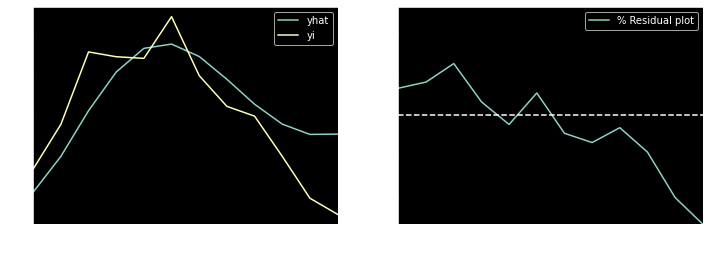

Mean Absolute % Error = 0.09
Root mean Squared error = 9.88 


In [242]:
# plots

fg,(ax1,ax2) = plt.subplots( 1,2, figsize= (12,4) )

yhat.plot( ax= ax1, label= 'yhat' )
ice_Test_Ser.plot( ax= ax1, label= 'yi' )
ax1.legend(); ax1.set_xlabel('')

yi_yhat_100.plot( ax= ax2, label= '% Residual plot' )
ax2.axhline( y=0, linestyle= '--' )
ax2.set_ylim( bottom=  -max( abs(min(yi_yhat_100)), abs(max(yi_yhat_100)) ),
              top=      max( abs(min(yi_yhat_100)), abs(max(yi_yhat_100)) )  )
ax2.legend(); ax2.set_xlabel('')

plt.show()

# model stats
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_100/100)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat**2)),2) } ' )

<br>

###  `MA` model

### $y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$ &emsp;&emsp;| &emsp;&emsp; $\varepsilon_t \sim N(0,1)$

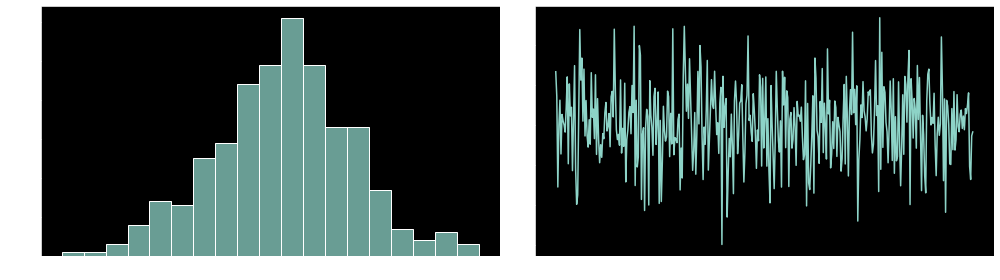

In [33]:
## data creation
np.random.seed(10)

err = np.random.normal( loc= 0.0, scale= 1.0, size= 400 )

date_indx = pd.date_range( start= '9/1/2019', end= '1/1/2020' )

fig,(ax1,ax2) = plt.subplots( 1,2, figsize= (14,4) )
sns.histplot( err, ax= ax1, binwidth= 0.3 )
ax2.plot( err )

plt.tight_layout()

#### $y_t = 50 + 0.4\varepsilon_{t-1} + 0.3\varepsilon_{t-2} + \varepsilon_t$

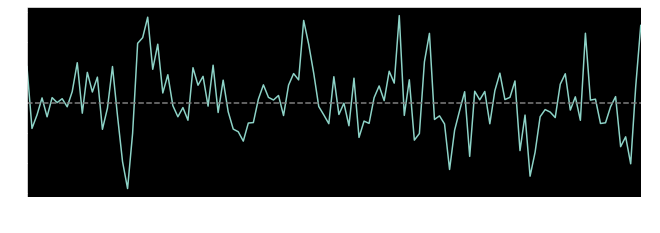

2019-09-01    51.196526
2019-09-02    49.140187
2019-09-03    49.588040
                ...    
2019-12-30    47.964736
2019-12-31    50.536092
2020-01-01    52.563673
Freq: D, Length: 123, dtype: float64


In [36]:
# simulated data creation and overview

mu = 50
y_ls = [ ( mu + 0.4*err[t-1] + 0.3*err[t-2] + err[t] ) for t in range(1,len(date_indx)+1) ]

y_Ser = pd.Series( y_ls, index= date_indx )
y_Ser = y_Ser.asfreq( freq= pd.infer_freq(y_Ser.index) )

y_Ser.plot( figsize= (11,3.5) )
plt.axhline( y= mu, linestyle= '--', color= 'grey' )
plt.show()

print( y_Ser )

In [321]:
# ACF & PACF
from statsmodels.tsa.stattools import acf, pacf

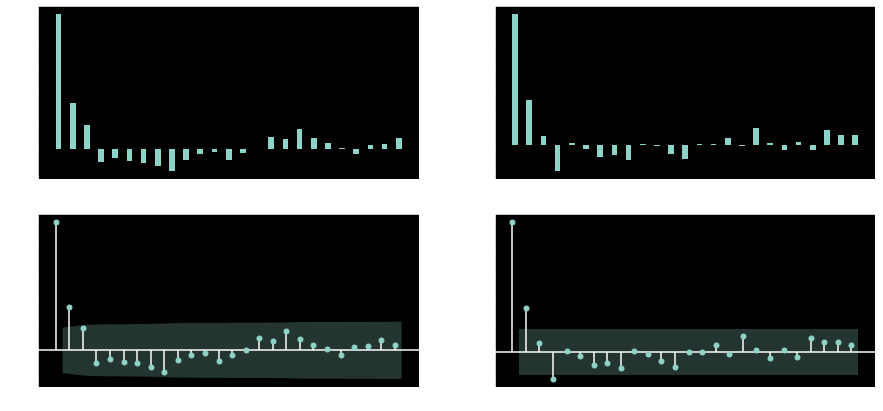

In [37]:
acf_val = acf(y_Ser)   ;                pacf_val= pacf(y_Ser)

num_lag = 25

fg,ax = plt.subplots( 2,2, figsize= (15,7) )

ax[0,0].bar( x= range(num_lag), height= acf_val[:num_lag], width= 0.4 )
ax[0,1].bar( x= range(num_lag), height= pacf_val[:num_lag], width= 0.4 )

plot_acf(  y_Ser, lags= num_lag, ax= ax[1,0], alpha= 0.05 )
plot_pacf( y_Ser, lags= num_lag, ax= ax[1,1], alpha= 0.05 )

plt.show()

In [362]:
# Train-test set

train_endDt = datetime.datetime( 2019,12,30 )
test_endDt  = datetime.datetime( 2020,1,1 )

y_Train_Ser = y_Ser[ :train_endDt ]
y_Test_Ser = y_Ser[ train_endDt + datetime.timedelta(days=1) : test_endDt ]

In [372]:
# fitting model

arimaModel_fit = ARIMA( y_Train_Ser, order= (0,0,2) ).fit()
print( arimaModel_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  121
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -166.467
Date:                Wed, 19 May 2021   AIC                            340.934
Time:                        23:13:29   BIC                            352.117
Sample:                    09-01-2019   HQIC                           345.476
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.0362      0.149    334.756      0.000      49.743      50.329
ma.L1          0.3654      0.083      4.422      0.000       0.203       0.527
ma.L2          0.3144      0.081      3.905      0.0

####  prediction & residual:
Predicted Model:  $\hat{y}_t = 50.04 + 0.37\varepsilon_{t-1} + 0.31\varepsilon_{t-2}$

In [383]:
# model prediction

yhat = arimaModel_fit.predict( start= y_Test_Ser.index[0], end= y_Test_Ser.index[-1] )

yi_yhat = y_Test_Ser - yhat  ;             yi_yhat_100 = ( y_Test_Ser - yhat )/y_Test_Ser*100

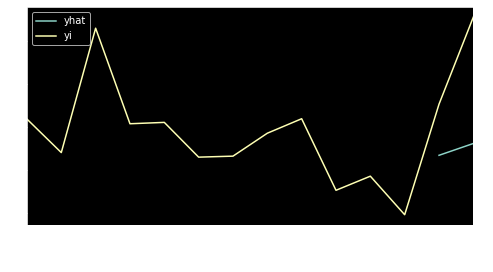

Mean Absolute % Error = 0.04
Root mean Squared error = 2.24 


In [390]:
# plots

fg,ax1 = plt.subplots(  figsize= (8,4) )

yhat.plot( ax= ax1, label= 'yhat' )
y_Ser[-14:].plot( ax= ax1, label= 'yi' )
ax1.legend(); ax1.set_xlabel('')
plt.show()

# model stats
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_100/100)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat**2)),2) } ' )

<br>

###   `ARMA` model (model on 1st difference)

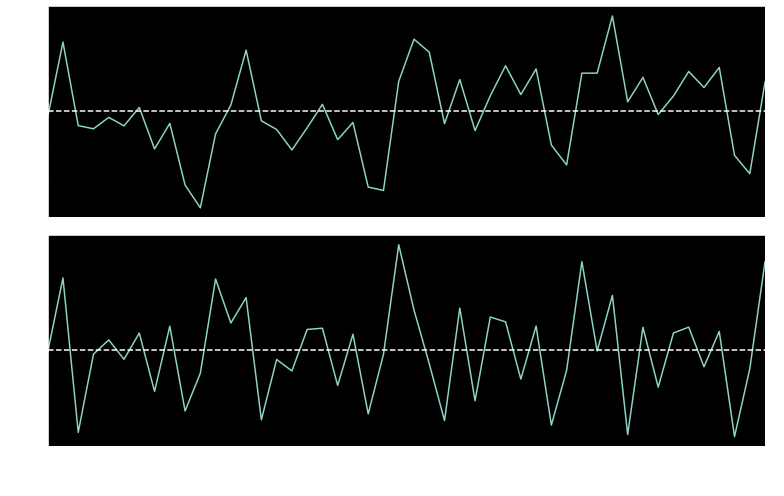

Date
2000-01-01    25412
2000-02-01    25354
2000-03-01    29161
              ...  
2003-11-01    23416
2003-12-01    22482
2004-01-01    27140
Freq: MS, Name: Total, Length: 49, dtype: int64


In [545]:
catfsh_Ser = pd.read_csv( 'datasets/catfish.csv', parse_dates= ['Date'], index_col= 'Date', squeeze= True )

# infer the frequency of the data
catfsh_Ser = catfsh_Ser.asfreq( freq= pd.infer_freq(catfsh_Ser.index) )

start_dt = datetime.datetime( 2000,1,1 )
catfsh_Ser = catfsh_Ser[ start_dt: '2004-01-01' ]

fg,(ax1,ax2) = plt.subplots( 2,1, figsize= (11,7), sharex= True )
catfsh_Ser.plot( ax= ax1 );   ax1.axhline( y= catfsh_Ser.mean(), linestyle= '--' )

# diff : because the data looks like is increasing so making it stationary
catfsh_Diff1_Ser = catfsh_Ser.diff().dropna()
catfsh_Diff1_Ser.plot( ax= ax2 );   ax2.axhline( y= catfsh_Diff1_Ser.mean(), linestyle= '--' )

plt.tight_layout(); plt.show()
print( catfsh_Ser )


#### `ACF` & `PACF`

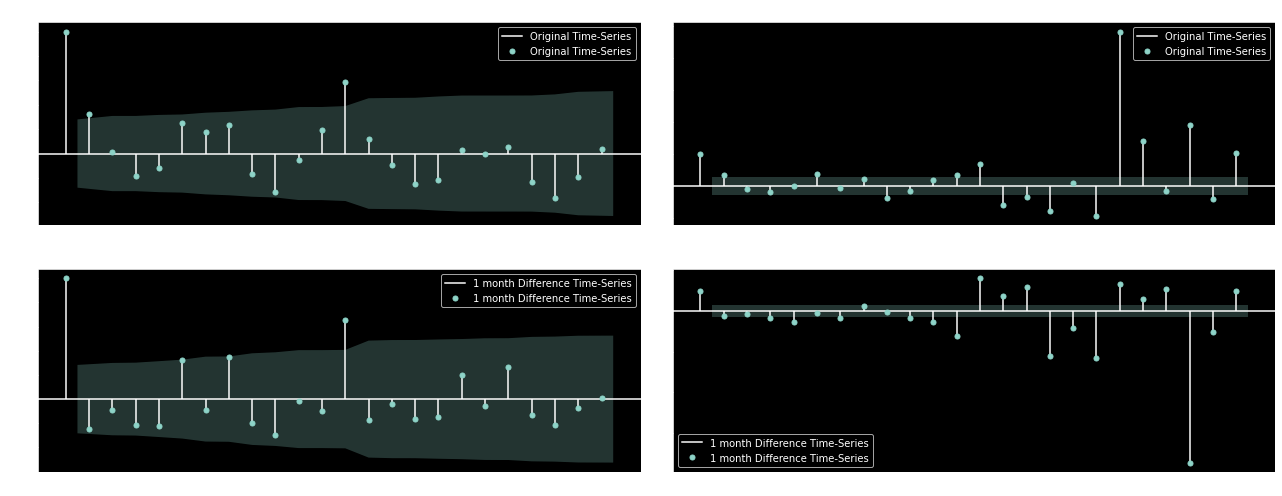

In [550]:
fg, ax = plt.subplots( 2,2, figsize= (18,7), squeeze= True )

lag_num = 23

plot_acf( catfsh_Ser, lags= lag_num, alpha= 0.05, ax= ax[0][0] , label = 'Original Time-Series' )
plot_pacf( catfsh_Ser, lags= lag_num, alpha= 0.05, ax= ax[0][1], label = 'Original Time-Series' )

plot_acf( catfsh_Diff1_Ser, lags= lag_num, alpha= 0.05, ax= ax[1][0] , label = '1 month Difference Time-Series' )
plot_pacf( catfsh_Diff1_Ser, lags= lag_num, alpha= 0.05, ax= ax[1][1], label = '1 month Difference Time-Series' )

set_Xticks_for_axes( ax_ls= ax, minor_major= (1,5) )

[ e_ax.legend() for e_ax in ax.flatten() ];

plt.tight_layout(); plt.show()

Based on ACF & PACF, we will consider `ARMA(4,1)`

In [552]:
# Train-test set of Diff

train_endDt = datetime.datetime( 2003,7,1 )
test_endDt  = datetime.datetime( 2004,1,1 )

catfsh_Train_Ser = catfsh_Diff1_Ser[ : train_endDt ]
catfsh_Test_Ser  = catfsh_Diff1_Ser[ train_endDt + datetime.timedelta(days=1) : test_endDt ]

In [555]:
# fitting model

armaModel_fit = ARMA( catfsh_Train_Ser, order= (4,1) ).fit()

print( armaModel_fit.summary() )

                              ARMA Model Results                              
Dep. Variable:                  Total   No. Observations:                   42
Model:                     ARMA(4, 1)   Log Likelihood                -376.584
Method:                       css-mle   S.D. of innovations           1850.781
Date:                Wed, 19 May 2021   AIC                            767.167
Time:                        22:17:20   BIC                            779.331
Sample:                    02-01-2000   HQIC                           771.626
                         - 07-01-2003                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.3231    129.751      0.288      0.774    -216.984     291.631
ar.L1.Total    -0.8666      0.185     -4.692      0.000      -1.229      -0.505
ar.L2.Total    -0.4236      0.166     -2.547    

#### The pvalue of constant > 0.05 so not using that in the model:

#### $\hat{y_t} = -0.87y_{t-1} - 0.42y_{t-2} - 0.56y_{t-3} - 0.61y_{t-4} + 0.52\varepsilon_{t-1}$

In [556]:
# model prediction

yhat = armaModel_fit.predict( start= catfsh_Test_Ser.index[0], end= catfsh_Test_Ser.index[-1] )
yi_yhat = catfsh_Test_Ser - yhat
yi_yhat_100 = yi_yhat/catfsh_Test_Ser*100

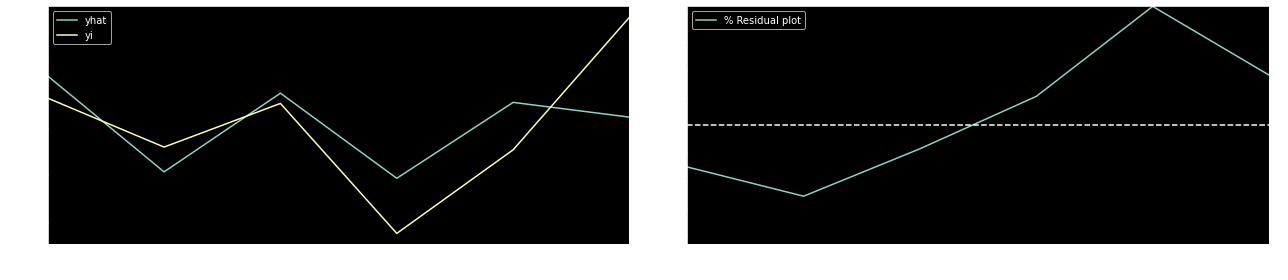

Mean Absolute % Error = 1.0
Root mean Squared error = 2210.26 


In [565]:
# plots
Test_set = catfsh_Test_Ser

fg,(ax1,ax2) = plt.subplots( 1,2, figsize= (18,4) )

yhat.plot( ax= ax1, label= 'yhat' )
Test_set.plot( ax= ax1, label= 'yi' )
ax1.legend(); ax1.set_xlabel('')

yi_yhat_100.plot( ax= ax2, label= '% Residual plot' )
ax2.axhline( y=0, linestyle= '--' )
ax2.set_ylim( bottom=  -max( abs(min(yi_yhat_100)), abs(max(yi_yhat_100)) ),
              top=      max( abs(min(yi_yhat_100)), abs(max(yi_yhat_100)) )  )
ax2.legend(); ax2.set_xlabel('')

plt.tight_layout();  plt.show()

# model stats
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_100/100)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat**2)),2) } ' )

<br>

###  `SARIMA` model

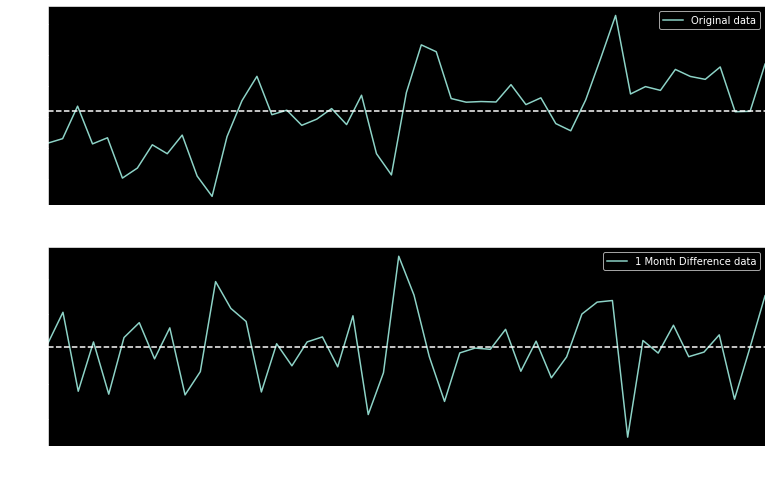

Date
1996-01-01    20322
1996-02-01    20613
1996-03-01    22704
              ...  
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name: Total, Length: 49, dtype: int64


In [14]:
catfsh_Ser = pd.read_csv( 'datasets/catfish.csv', parse_dates= ['Date'], index_col= 'Date', squeeze= True )

# infer the frequency of the data
catfsh_Ser = catfsh_Ser.asfreq( freq= pd.infer_freq(catfsh_Ser.index) )

start_dt = datetime.datetime( 1996,1,1 )
catfsh_Ser = catfsh_Ser[ start_dt: '2000-01-01' ]

fg,(ax1,ax2) = plt.subplots( 2,1, figsize= (11,7), )
catfsh_Ser.plot( ax= ax1, label= 'Original data' );   ax1.axhline( y= catfsh_Ser.mean(), linestyle= '--' )

# diff : because the data looks like is increasing so trying to make it stationary
catfsh_Diff1_Ser = catfsh_Ser.diff().dropna()
catfsh_Diff1_Ser.plot( ax= ax2, label= '1 Month Difference data' );
ax2.axhline( y= catfsh_Diff1_Ser.mean(), linestyle= '--' )

[ e_ax.legend() for e_ax in (ax1,ax2) ];

plt.tight_layout(); plt.show()
print( catfsh_Ser )

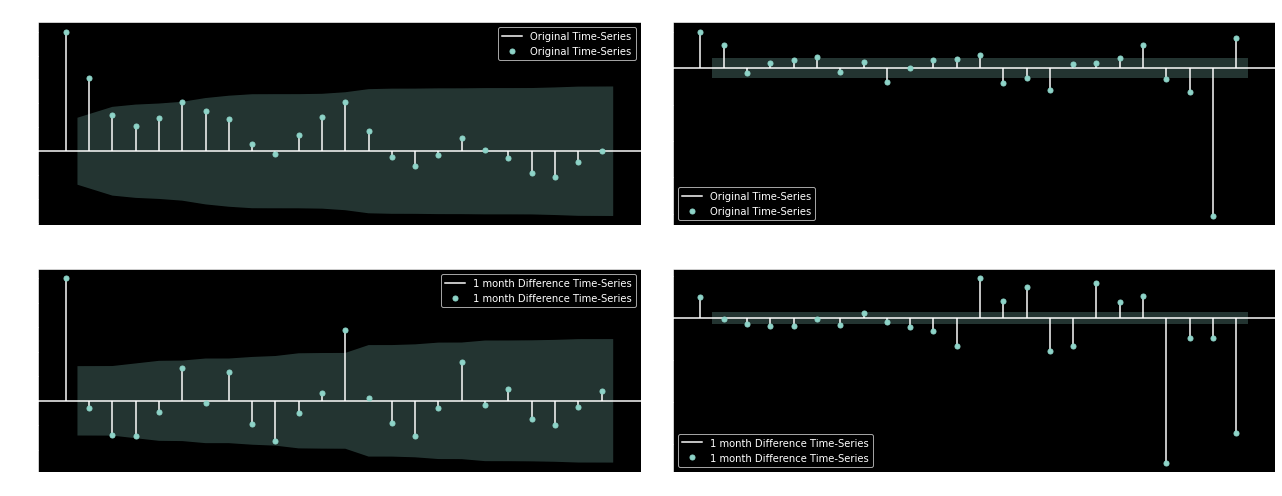

In [52]:
warnings.filterwarnings( action= 'ignore' )

fg, ax = plt.subplots( 2,2, figsize= (18,7), squeeze= True )

lag_num = 23

plot_acf(  catfsh_Ser, lags= lag_num, alpha= 0.05, ax= ax[0][0], label = 'Original Time-Series' )
plot_pacf( catfsh_Ser, lags= lag_num, alpha= 0.05, ax= ax[0][1], label = 'Original Time-Series' )

plot_acf(  catfsh_Diff1_Ser, lags= lag_num, alpha= 0.05, ax= ax[1][0], label = '1 month Difference Time-Series' )
plot_pacf( catfsh_Diff1_Ser, lags= lag_num, alpha= 0.05, ax= ax[1][1], label = '1 month Difference Time-Series' )

set_Xticks_for_axes( ax_ls= ax, minor_major= (1,5) )

[ e_ax.legend() for e_ax in ax.flatten() ];
set_Xticks_for_axes( ax_ls= ax, minor_major= (1,5) )

plt.tight_layout(); plt.show()


    Based on ACF, we should start with a seasonal MA process
    Based on PACF, we should start with a seasonal AR process

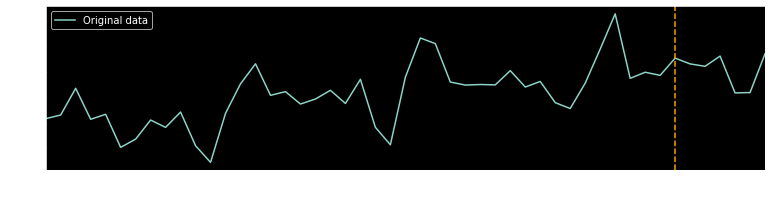

In [31]:
# Train-test set of Diff
train_endDt = datetime.datetime( 1999,7,1 );   test_endDt  = datetime.datetime( 2000,1,1 )

catfsh_Train_Ser = catfsh_Ser[ : train_endDt ]
catfsh_Test_Ser  = catfsh_Ser[ train_endDt + datetime.timedelta(days=1) : test_endDt ]

fg,ax1 = plt.subplots( figsize= (11,3) )
catfsh_Ser.plot( ax= ax1, label= 'Original data' );
ax1.axvline( x= train_endDt, linestyle= '--', color= 'orange' )
ax1.legend();  plt.tight_layout();  plt.show()

In [84]:
# fitting SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

pqr_order  = ( 0,1,0 )
PQRs_order = ( 1,0,1, 12 )

sarimaModel_fit1 = SARIMAX( catfsh_Train_Ser, order= pqr_order, seasonal_order= PQRs_order ).fit()

print( sarimaModel_fit1.summary() )

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Wed, 26 May 2021   AIC                            737.270
Time:                                      19:09:05   BIC                            742.483
Sample:                                  01-01-1996   HQIC                           739.181
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8255      0.120      6.899      0.000       0.591       1.060
ma.S.L12      -0.51

In [60]:
pqr_order  = ( 0,1,0 );     PQRs_order = ( 1,0,1, 12 )
sarimaModel_fit1 = SARIMAX( catfsh_Train_Ser, order= pqr_order, seasonal_order= PQRs_order ).fit()
residual1 = (sarimaModel_fit1.resid/catfsh_Train_Ser*100)[1:]

pqr_order  = ( 0,1,0 );     PQRs_order = ( 1,0,1, 20 )
sarimaModel_fit2 = SARIMAX( catfsh_Train_Ser, order= pqr_order, seasonal_order= PQRs_order ).fit()
residual2 = (sarimaModel_fit2.resid/catfsh_Train_Ser*100)[1:]

pqr_order  = ( 1,1,1 );     PQRs_order = ( 1,0,1, 12 )
sarimaModel_fit3 = SARIMAX( catfsh_Train_Ser, order= pqr_order, seasonal_order= PQRs_order ).fit()
residual3 = (sarimaModel_fit3.resid/catfsh_Train_Ser*100)[1:]

pqr_order  = ( 1,1,1 );     PQRs_order = ( 1,0,1, 20 )
sarimaModel_fit4 = SARIMAX( catfsh_Train_Ser, order= pqr_order, seasonal_order= PQRs_order ).fit()
residual4 = (sarimaModel_fit4.resid/catfsh_Train_Ser*100)[1:]

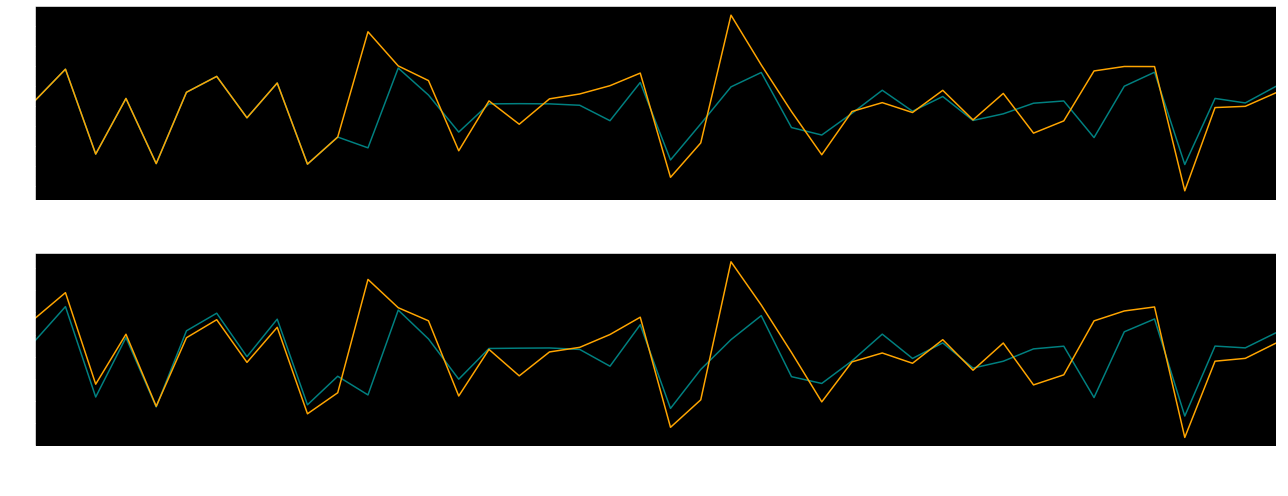

In [80]:
fg, (ax1,ax2) = plt.subplots( 2,1, figsize= (18,3.5*2), squeeze= True )

residual1.plot( ax= ax1, color= 'teal'   )
residual2.plot( ax= ax1, color= 'orange' )

residual3.plot( ax= ax2, color= 'teal' )
residual4.plot( ax= ax2, color= 'orange' )

set_ticks_for_axes( ax_ls= [ax1,ax2], x_y= 'y', minor_major= (5,10) )

plt.tight_layout(); plt.show()

In [91]:
# model forecast
yhat = sarimaModel_fit1.forecast( steps= len(catfsh_Test_Ser) )

yi_yhat = catfsh_Test_Ser - yhat
yi_yhat_100 = yi_yhat/catfsh_Test_Ser*100

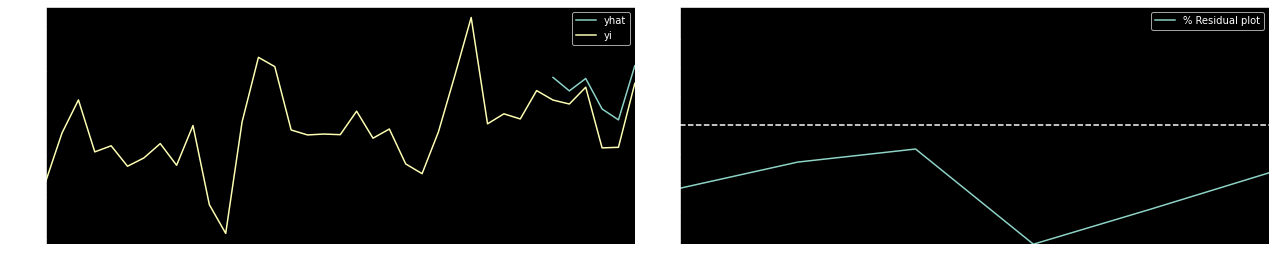

Mean Absolute % Error = 0.04
Root mean Squared error = 1121.99 


In [97]:
# plots
Test_set = catfsh_Test_Ser

fg,(ax1,ax2) = plt.subplots( 1,2, figsize= (18,4) )

yhat.plot( ax= ax1, label= 'yhat' )
catfsh_Ser['1997':].plot( ax= ax1, label= 'yi' )
ax1.legend(); ax1.set_xlabel('')

yi_yhat_100.plot( ax= ax2, label= '% Residual plot' )
ax2.axhline( y=0, linestyle= '--' )
ax2.set_ylim( bottom=  -max( abs(min(yi_yhat_100)), abs(max(yi_yhat_100)) ),
              top=      max( abs(min(yi_yhat_100)), abs(max(yi_yhat_100)) )  )
ax2.legend(); ax2.set_xlabel('')

plt.tight_layout();  plt.show()

# # model stats
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_100/100)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat**2)),2) } ' )

In [98]:
catfsh_Test_Ser

Date
1999-08-01    24618
1999-09-01    24430
1999-10-01    25229
1999-11-01    22344
1999-12-01    22372
2000-01-01    25412
Freq: MS, Name: Total, dtype: int64

In [100]:
warnings.filterwarnings( action= 'ignore' )

yhat_roll = pd.Series( dtype= float )
pqr_order  = ( 0,1,0 );     PQRs_order = ( 1,0,1, 12 )

for e_endDt in catfsh_Test_Ser.index:
    day1 = datetime.timedelta(days=1)
    catfsh_Train_Roll_Ser = catfsh_Ser[ : e_endDt - day1 ]
    
    sarimaModel_fit = SARIMAX( catfsh_Train_Roll_Ser, order= pqr_order, seasonal_order= PQRs_order ).fit()
    yhat = sarimaModel_fit.forecast( steps= 1 )
    yhat_roll.loc[e_endDt] = yhat.loc[e_endDt]
    
yi_yhat_Roll = catfsh_Test_Ser - yhat_roll

yi_yhat_Roll_percent = yi_yhat_Roll/catfsh_Test_Ser * 100

# model stats
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_Roll_percent/100)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat_Roll**2)),2) } ' )

Mean Absolute % Error = 0.03
Root mean Squared error = 804.28 


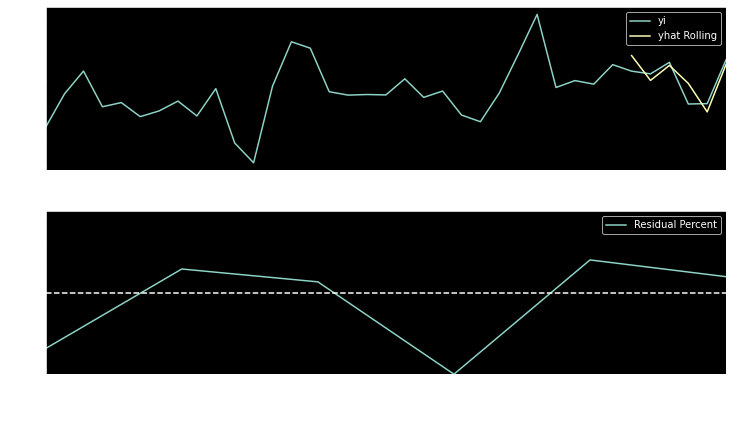

Mean Absolute % Error = 0.03
Root mean Squared error = 804.28 


In [110]:
# plots

Test_set = catfsh_Test_Ser

fg = plt.figure()
gs = GridSpec( 2,2, figure= fg, top= 1.4, right= 1.7, hspace= 0.25, wspace= 0.2 )

ax1 = fg.add_subplot( gs[0,:] )
# Test_set.plot( ax= ax1 );
catfsh_Ser['1997':].plot( ax= ax1, label= 'yi' )
yhat_roll.plot( ax= ax1, label= 'yhat Rolling' )
ax1.legend()

ax2 = fg.add_subplot( gs[1,:] )
yi_yhat_Roll_percent.plot( ax= ax2, label= 'Residual Percent' )
ax2.axhline( y= 0, linestyle= '--' )
ax2.set_ylim( bottom=  -max( abs(min(yi_yhat_Roll_percent)), abs(max(yi_yhat_Roll_percent)) ),
              top=      max( abs(min(yi_yhat_Roll_percent)), abs(max(yi_yhat_Roll_percent)) ) )
ax2.legend()

plt.tight_layout(); plt.show()

# model stats
print( f'Mean Absolute % Error = { np.round(np.mean(abs(yi_yhat_Roll_percent/100)),2) }\n\
Root mean Squared error = { np.round(np.sqrt(np.mean(yi_yhat_Roll**2)),2) } ' )

<br>

###   `GARCH` - Generalized AutoRegressive Conditional Heteroskedasticity model

#### `GARCH(2,2)` Model

$$
y_t = \varepsilon_t \sqrt{\omega + \alpha_1 y_{t-1}^2 + \alpha_2 y_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2}
$$

$$ a_0, a_1 \sim \mathcal{N}(0,1) $$
$$ \sigma_0 =1, \sigma_1 = 1 $$
$$ \varepsilon_t \sim \mathcal{N}(0,1) $$

In [263]:
from arch import arch_model

# create fictious but resonable dataset
np.random.seed(10)

n = 1000

w = 0.5; a1 = 0.1; a2 = 0.2; b1 = 0.3; b2 = 0.4

tst_sz = int( n*10/100 )

yti = [ random.gauss(0,1), random.gauss(0,1) ]
σti = [ 1,1 ]

for _ in range(n):
    σt = np.sqrt( w + a1*yti[-1]**2 + a2*yti[-2]**2  +  b1*σti[-1]**2 + b2*σti[-2]**2 )
    
    ϵt = random.gauss( 0,1 )
    yt = ϵt * σt                    #  yt =  ϵt . σt
    
    yti.append(yt); σti.append(σt)

$$
y_t = \varepsilon_t \sqrt{\omega + \alpha_1 y_{t-1}^2 + \alpha_2 y_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2}
$$

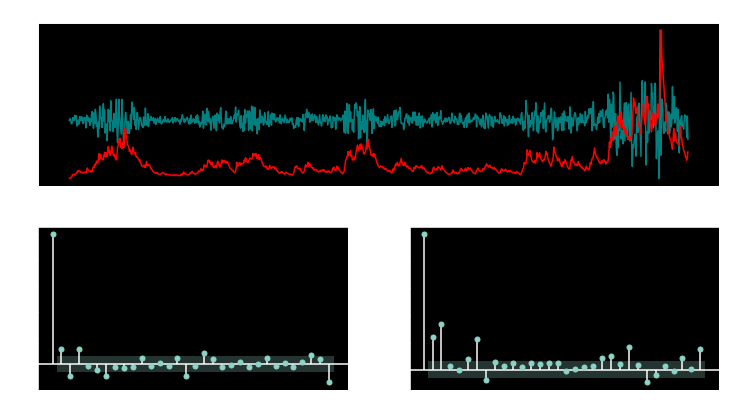

In [264]:
fg = plt.figure()
gs = GridSpec( 2,2, figure= fg, top= 1.4, right= 1.7, hspace= 0.25, wspace= 0.2 )
warnings.filterwarnings( action= 'ignore' )

ax1 = fg.add_subplot( gs[0,:] )
ax1.plot( yti, color= 'teal' )
ax1.set_title( 'Simulated GARCH(2,2) Data (yt) & Volatility (σt)', fontsize= 12 )
ax1_ = ax1.twinx()
ax1_.plot( σti, color= 'red' )

ax2a = fg.add_subplot( gs[1,0] )
plot_pacf( np.array(yti), ax= ax2a )
ax2a.set_title( 'PACF of yt', fontsize= 12 )

ax2b = fg.add_subplot( gs[1,1] )
plot_pacf( np.array(yti)**2, ax= ax2b )
ax2b.set_title( 'PACF of yt^2 <-- we need to consider this', fontsize= 12 )

plt.tight_layout();  plt.show()

#### Fit the model

In [265]:
# train test
train_yt, test_yt = yti[ :-tst_sz ], yti[ -tst_sz: ]

# model fit
garchModel_fit = arch_model( y= train_yt, p= 2, q= 2, vol= 'Garch' ).fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2408.0712117051944
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2405.806688916672
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2404.2494667054857
Iteration:      4,   Func. Count:     38,   Neg. LLF: 2403.4188489728026
Iteration:      5,   Func. Count:     48,   Neg. LLF: 2403.37569092482
Iteration:      6,   Func. Count:     57,   Neg. LLF: 2402.4888777239794
Iteration:      7,   Func. Count:     66,   Neg. LLF: 2402.3316703013065
Iteration:      8,   Func. Count:     75,   Neg. LLF: 2402.284338215462
Iteration:      9,   Func. Count:     83,   Neg. LLF: 2402.2012984937032
Iteration:     10,   Func. Count:     91,   Neg. LLF: 2402.1708147607105
Iteration:     11,   Func. Count:    101,   Neg. LLF: 2402.1692720446354
Iteration:     12,   Func. Count:    109,   Neg. LLF: 2402.1533249787553
Iteration:     13,   Func. Count:    117,   Neg. LLF: 2402.152757909145
Iteration:     14,   Func. Count:    125,   Neg. LLF: 24

In [266]:
print( garchModel_fit.summary() )

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2402.15
Distribution:                  Normal   AIC:                           4816.31
Method:            Maximum Likelihood   BIC:                           4845.13
                                        No. Observations:                  902
Date:                Thu, May 27 2021   Df Residuals:                      901
Time:                        21:08:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0402  8.712e-02     -0.461      0.645 [ -0.211,  0.13

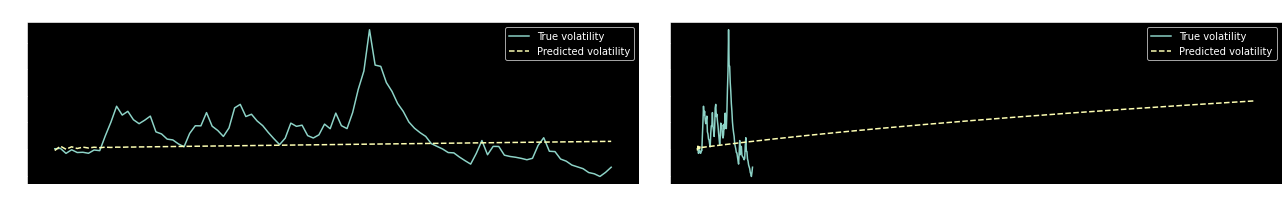

In [268]:
# model forecast

fg, (ax1,ax2) = plt.subplots( 1,2, figsize= (18,3) )

yhat = garchModel_fit.forecast( horizon= tst_sz )

ax1.plot( σti[ -tst_sz: ],  label= 'True volatility' )
ax1.plot( np.sqrt( yhat.variance.values[-1,:] ), label= 'Predicted volatility', linestyle= '--' )
ax1.set_title( 'volatility Prediction' ); ax1.legend()


yhat = garchModel_fit.forecast( horizon= 1000 )

ax2.plot( σti[ -tst_sz: ],  label= 'True volatility' )
ax2.plot( np.sqrt( yhat.variance.values[-1,:] ), label= 'Predicted volatility', linestyle= '--' )


ax2.set_title( 'Long-term volatility Prediction (Bad idea)' ); ax2.legend()

plt.tight_layout()

#### Rolling Forecast

In [269]:
warnings.filterwarnings( action= 'ignore' )

yhat_roll = []

for i in range(tst_sz):
    e_train_yt = yti[ : -(tst_sz-i) ]
    e_garchModel_fit = arch_model( y= e_train_yt, p= 2, q= 2, vol= 'Garch' ).fit( disp= 'off' )
    yhat = e_garchModel_fit.forecast( horizon= 1 )
    yhat_roll.append( np.sqrt( yhat.variance.values[-1,:][0] ) )

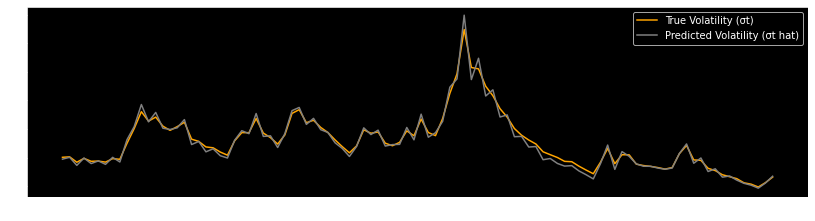

In [274]:
fg,ax = plt.subplots( figsize= (14,3.5) )

ax.plot( σti[ -tst_sz: ], label= 'True Volatility (σt)', color= 'orange' )
ax.plot( yhat_roll, label= 'Predicted Volatility (σt hat)', color= 'gray' )
ax.legend()

plt.show()

<br>

###  Stock Forecasting with `GARCH`
<i>[Go to top](#toc)</i>

In [6]:
import pandas_datareader.data as pdr

start_dt = datetime.datetime( 2015,1,1 );        end_dt = datetime.datetime( 2020,6,10 )

dis_df = pdr.DataReader( name= 'DIS', data_source= 'yahoo', start= start_dt, end= end_dt )
print( dis_df )

                  High         Low        Open       Close      Volume  \
Date                                                                     
2015-01-02   95.279999   92.849998   94.910004   93.750000   5865400.0   
2015-01-05   93.349998   91.779999   93.279999   92.379997   7789400.0   
2015-01-06   93.190002   91.160004   92.570000   91.889999   6793100.0   
...                ...         ...         ...         ...         ...   
2020-06-08  127.440002  123.940002  125.099998  127.279999  13858100.0   
2020-06-09  125.790001  123.510002  125.629997  123.889999  10882800.0   
2020-06-10  124.099998  120.930000  124.019997  122.180000  11497100.0   

             Adj Close  
Date                    
2015-01-02   87.376266  
2015-01-05   86.099403  
2015-01-06   85.642708  
...                ...  
2020-06-08  127.279999  
2020-06-09  123.889999  
2020-06-10  122.180000  

[1369 rows x 6 columns]


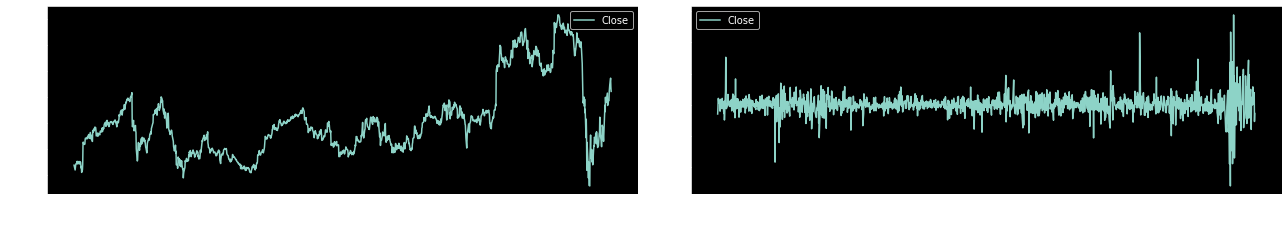

In [56]:
dis_pct_df = 100 * dis_df['Close'].pct_change().dropna()

fg,(ax1,ax2) = plt.subplots( 1,2, figsize= (18,3.5) )

dis_df['Close'].plot( ax= ax1 ) ;       dis_pct_df.plot( ax= ax2 )

ax1.set( ylabel= 'stock price' );       ax2.set( ylabel= 'Percent Return' )
[ e_ax.legend() for e_ax in [ax1,ax2] ]
plt.tight_layout()

#### to find the `GARCH` model order: observing `PACF`

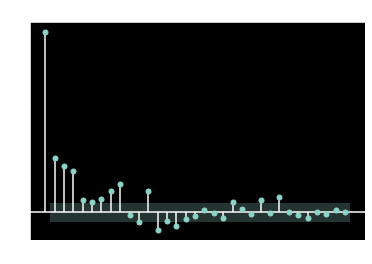

In [23]:
plot_pacf( dis_pct_df**2 ); plt.show()

#### Fit `Garch (3,3)` model

In [24]:
garchModel_fit = arch_model( y= dis_pct_df, p=3,q=3, vol= 'Garch' ).fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 2325.115878850809
Iteration:      2,   Func. Count:     23,   Neg. LLF: 2324.595359134287
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2321.1880449514692
Iteration:      4,   Func. Count:     46,   Neg. LLF: 2314.4297591020268
Iteration:      5,   Func. Count:     57,   Neg. LLF: 2310.6249217785044
Iteration:      6,   Func. Count:     68,   Neg. LLF: 2304.138956529934
Iteration:      7,   Func. Count:     79,   Neg. LLF: 2303.0348298313147
Iteration:      8,   Func. Count:     90,   Neg. LLF: 2302.217143344581
Iteration:      9,   Func. Count:    101,   Neg. LLF: 2301.2155552948943
Iteration:     10,   Func. Count:    111,   Neg. LLF: 2299.0799635804765
Iteration:     11,   Func. Count:    122,   Neg. LLF: 2298.9853663046733
Iteration:     12,   Func. Count:    132,   Neg. LLF: 2298.9516133971765
Iteration:     13,   Func. Count:    142,   Neg. LLF: 2298.9391229871517
Iteration:     14,   Func. Count:    152,   Neg. LLF: 2

In [26]:
print( garchModel_fit.summary() )

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2298.92
Distribution:                  Normal   AIC:                           4613.84
Method:            Maximum Likelihood   BIC:                           4655.61
                                        No. Observations:                 1368
Date:                Fri, May 28 2021   Df Residuals:                     1367
Time:                        14:53:10   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.0139e-03  4.319e-02     -0.162      0.

#### Try `Garch (3,0)` ≡ `ARCH(3)` model

In [29]:
garchModel_fit = arch_model( y= dis_pct_df, p=3,q=0 ).fit( disp= 'off' )
print( garchModel_fit.summary() )

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2314.08
Distribution:                  Normal   AIC:                           4638.15
Method:            Maximum Likelihood   BIC:                           4664.26
                                        No. Observations:                 1368
Date:                Fri, May 28 2021   Df Residuals:                     1367
Time:                        14:57:35   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.7994e-03  3.990e-02      0.246      0.806 

#### Rolling Forecast

In [40]:
warnings.filterwarnings( action= 'ignore' )

yhat_roll = []

tst_sz = 365

for i in range(tst_sz):
    e_train_yt = dis_pct_df[ : -(tst_sz-i) ]
    e_garchModel_fit = arch_model( y= e_train_yt, p=3,q=0 ).fit( disp= 'off' )
    
    yhat = e_garchModel_fit.forecast( horizon= 1 )
    yhat_roll.append( np.sqrt( yhat.variance.values[-1,:][0] ) )
    
yhat_roll_Ser = pd.Series( yhat_roll, index= dis_pct_df.index[ -tst_sz: ] )

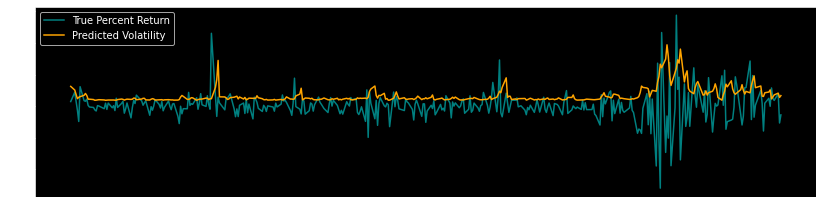

In [44]:
fg,ax = plt.subplots( figsize= (14,3.5) )

ax.plot( dis_pct_df[-tst_sz:], label= 'True Percent Return', color= 'teal' )
ax.plot( yhat_roll_Ser, label= 'Predicted Volatility', color= 'orange' )
ax.legend( loc= 'upper left' ); plt.show()

<br>

#### S&P 500 stocks `Garch` model building

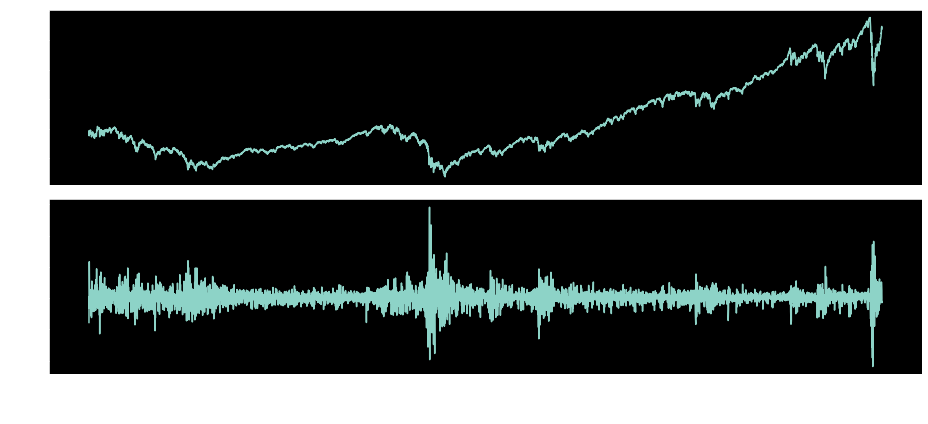

In [68]:
start_dt = datetime.datetime(2000,1,1);  end_dt = datetime.datetime(2020,6,10);

snp_df = pdr.DataReader( name= 'SPY', data_source= 'yahoo', start= start_dt, end= end_dt )
snp_pct_df = 100*snp_df['Close'].pct_change().dropna()
snp_pct_df

fg,(ax1,ax2) = plt.subplots( 2,1, figsize= (13,6), sharex= True )

snp_df['Close'].plot( ax= ax1 );            snp_pct_df.plot( ax= ax2 )
ax1.set( ylabel= 'stock price' );           ax2.set( ylabel= 'Percent Return' )
plt.tight_layout(); plt.show()

#### to find the `GARCH` model order: observing `PACF`

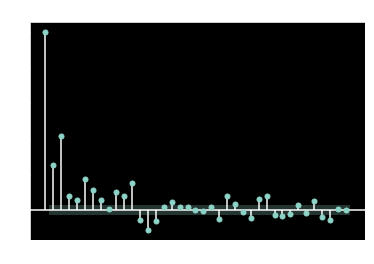

In [69]:
plot_pacf( snp_pct_df**2 ); plt.show()

#### Fit `Garch (2,2)` model

In [70]:
garchModel_fit = arch_model( y= snp_pct_df, p=2,q=2,  ).fit( )

Iteration:      1,   Func. Count:      8,   Neg. LLF: 7063.849269096254
Iteration:      2,   Func. Count:     21,   Neg. LLF: 7059.949362433973
Iteration:      3,   Func. Count:     33,   Neg. LLF: 7059.912631632853
Iteration:      4,   Func. Count:     43,   Neg. LLF: 7059.364150027669
Iteration:      5,   Func. Count:     53,   Neg. LLF: 7054.846718303968
Iteration:      6,   Func. Count:     62,   Neg. LLF: 7054.357146455823
Iteration:      7,   Func. Count:     71,   Neg. LLF: 7053.885873265253
Iteration:      8,   Func. Count:     80,   Neg. LLF: 7053.660000757351
Iteration:      9,   Func. Count:     90,   Neg. LLF: 7053.649800194631
Iteration:     10,   Func. Count:     99,   Neg. LLF: 7053.570243379768
Iteration:     11,   Func. Count:    107,   Neg. LLF: 7053.566838787082
Iteration:     12,   Func. Count:    115,   Neg. LLF: 7053.566735130049
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7053.566735132504
            Iterations: 12


In [71]:
print( garchModel_fit.summary() )

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7053.57
Distribution:                  Normal   AIC:                           14119.1
Method:            Maximum Likelihood   BIC:                           14158.4
                                        No. Observations:                 5141
Date:                Fri, May 28 2021   Df Residuals:                     5140
Time:                        16:13:45   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0663  1.096e-02      6.054  1.411e-09 [4.

#### Rolling Forecast (for Volatility/Variability)

In [73]:
warnings.filterwarnings( action= 'ignore' )

yhat_roll = []

tst_sz = 5 * 365

for i in range(tst_sz):
    e_train_yt = snp_pct_df[ : -(tst_sz-i) ]
    e_garchModel_fit = arch_model( y= e_train_yt, p=2,q=2 ).fit( disp= 'off' )
    
    yhat = e_garchModel_fit.forecast( horizon= 1 )
    yhat_roll.append( np.sqrt( yhat.variance.values[-1,:][0] ) )
    
yhat_roll_Ser = pd.Series( yhat_roll, index= snp_pct_df.index[ -tst_sz: ] )

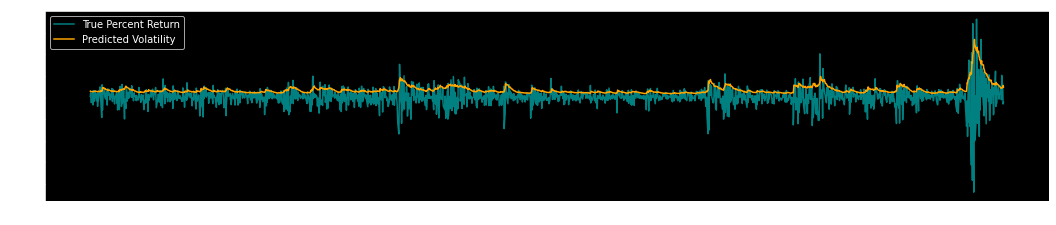

In [75]:
fg,ax = plt.subplots( figsize= (18,3.5) )

ax.plot( snp_pct_df[-tst_sz:], label= 'True Percent Return', color= 'teal' )
ax.plot( yhat_roll_Ser, label= 'Predicted Volatility', color= 'orange' )
ax.legend( loc= 'upper left' ); plt.show()


#### using the model to forecast

In [83]:
TRAIN_snpPct_df = snp_pct_df

garchModel_fit = arch_model( y= TRAIN_snpPct_df, p=2,q=2 ).fit( disp= 'off' )

In [84]:
yhat = garchModel_fit.forecast( horizon= 7 )
future_date = [ TRAIN_snpPct_df.index[-1] + datetime.timedelta(days=i) for i in range(1,8) ]
yhat_Ser = pd.Series(  np.sqrt( yhat.variance.values[-1,:] ), index= future_date  )

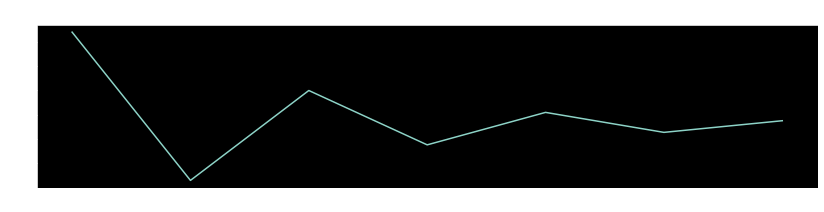

In [89]:
fg,ax = plt.subplots( figsize= (14,3) )
ax.plot( yhat_Ser )

ax.set_title(  'Volatility Prediction - Next 7 Days', fontsize= 15 ); plt.show()

<br>

### `VAR` - Vector Auto Regression model

Predicting Heater sales using lagged Heater sales + lagged IceCream sales

### Processing and Transforming TimeSeries data prior to Model fit

In [55]:
def dt_parser_func(dt_str):
    return( datetime.datetime.strptime( dt_str, '%Y-%m' ) )

In [56]:
iceHeat_df = pd.read_csv( 'datasets/ice_cream_vs_heater.csv',
                          parse_dates= [0], date_parser= dt_parser_func, index_col= 0,
                          squeeze= True )

iceHeat_df.columns = clean_colm_name( iceHeat_df )

# confirming the frequency
iceHeat_df = iceHeat_df.asfreq( freq= pd.infer_freq(iceHeat_df.index) )
iceHeat_df

heater  ice_cream
Month                        
2004-01-01      27         13
2004-02-01      18         15
2004-03-01      14         16
...            ...        ...
2020-04-01      25         53
2020-05-01      27         70
2020-06-01      24         74

[198 rows x 2 columns]

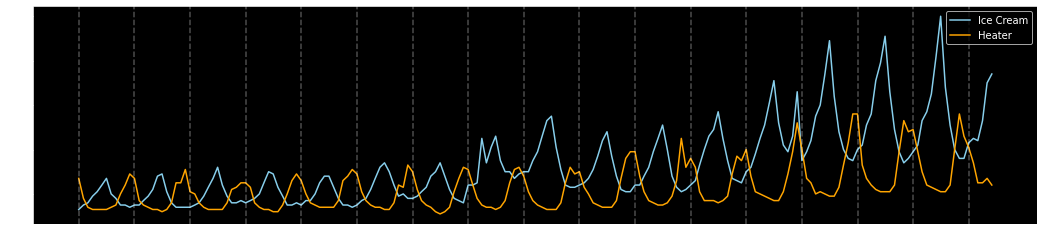

In [57]:
data_to_plot = iceHeat_df

fg,ax = plt.subplots( figsize= (18,4) )

ax.plot( data_to_plot['ice_cream'], label= 'Ice Cream', color= 'skyblue' )
ax.plot( data_to_plot['heater'], label= 'Heater', color= 'orange' )

[ ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.3 )\
  for e_yr in range( data_to_plot.index.min().year, data_to_plot.index.max().year+1 )  ];

ax.legend(); plt.show()

Predicting Heater sales using lagged Heater values + IceCream sales

#### Normalizing the data

In [58]:
def normalize_func( col ):
    normzd = ( col - col.mean() ) / col.std()
    return(normzd)

In [59]:
iceHeat_norm_df = iceHeat_df[ ['heater','ice_cream'] ].apply( func= normalize_func )

iceHeat_norm_df.columns = [ 'heat_norm','ice_norm' ]; print( iceHeat_norm_df.head(2) )

            heat_norm  ice_norm
Month                          
2004-01-01   0.429490 -1.174946
2004-02-01  -0.489299 -1.057807


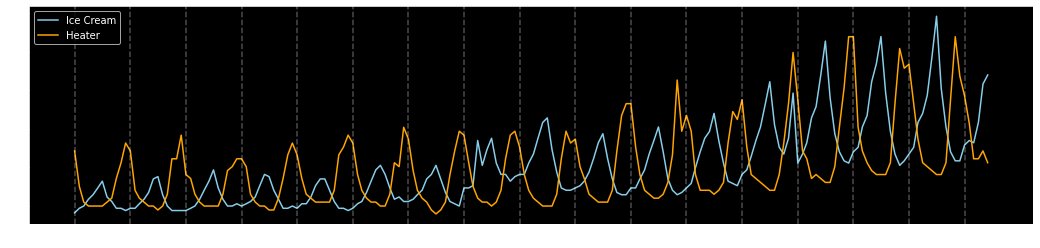

In [60]:
data_to_plot = iceHeat_norm_df

fg,ax = plt.subplots( figsize= (18,4) )

ax.plot( data_to_plot['ice_norm'], label= 'Ice Cream', color= 'skyblue' )
ax.plot( data_to_plot['heat_norm'], label= 'Heater', color= 'orange' )

[ ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.3 )\
  for e_yr in range( data_to_plot.index.min().year, data_to_plot.index.max().year+1 )  ];

ax.legend(); plt.show()

#### 1st difference to remove Trend

In [61]:
iceHeat_1stdiff_df = iceHeat_norm_df.diff().dropna()
iceHeat_1stdiff_df.columns = [ 'heat_norm_diff1', 'ice_norm_diff1' ]; print( iceHeat_1stdiff_df.head(2) )

            heat_norm_diff1  ice_norm_diff1
Month                                      
2004-02-01        -0.918789         0.11714
2004-03-01        -0.408351         0.05857


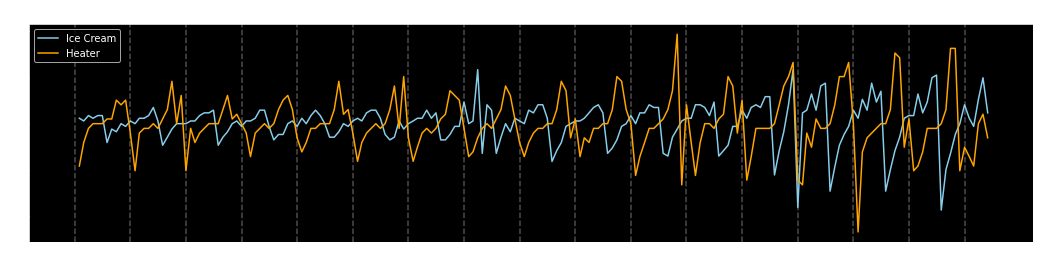

In [62]:
data_to_plot = iceHeat_1stdiff_df
fg,ax = plt.subplots( figsize= (18,4) )

[ ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.3 )\
  for e_yr in range( data_to_plot.index.min().year, data_to_plot.index.max().year+1 )  ];

ax.plot( data_to_plot['ice_norm_diff1'], label= 'Ice Cream', color= 'skyblue' )
ax.plot( data_to_plot['heat_norm_diff1'], label= 'Heater', color= 'orange' )

ax.set_title( 'Data after removing increasing Trend', fontsize= 15 ); ax.legend(); plt.show()

#### ACF & PACF after 1st difference

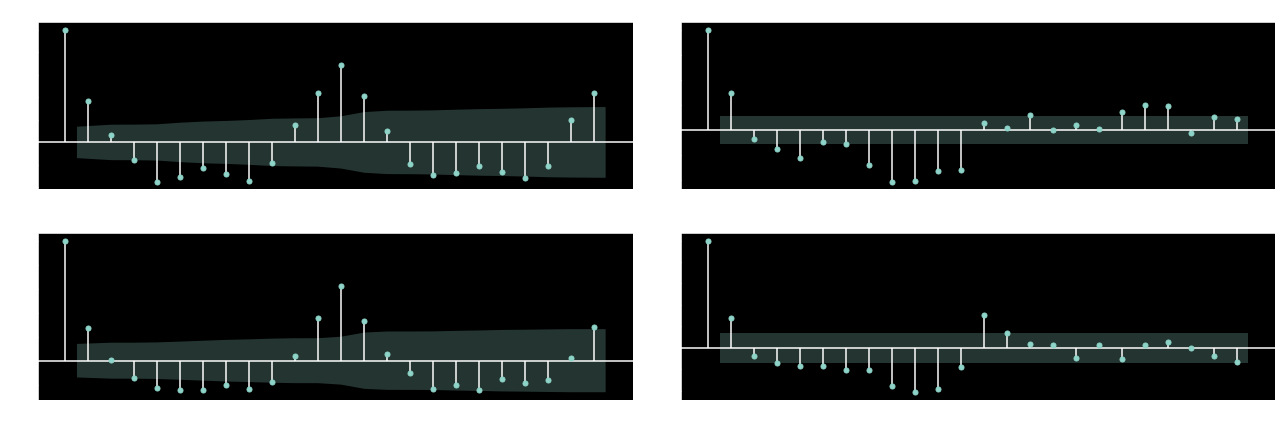

In [63]:
#### ACF & PACF after 1st difference
fg,ax = plt.subplots( 2,2, figsize= (18,3*2) )
plot_acf( data_to_plot['heat_norm_diff1'], ax= ax[0][0] )  ;  plot_pacf( data_to_plot['heat_norm_diff1'], ax= ax[0][1] )
plot_acf( data_to_plot['ice_norm_diff1'],  ax= ax[1][0] );  plot_pacf( data_to_plot['ice_norm_diff1'],  ax= ax[1][1] )
plt.tight_layout(); plt.show()

#### Remove Ice Cream increasing Volatility

    by dividing each value by yearly SD

In [64]:
print( iceHeat_1stdiff_df )

            heat_norm_diff1  ice_norm_diff1
Month                                      
2004-02-01        -0.918789        0.117140
2004-03-01        -0.408351        0.058570
2004-04-01        -0.102088        0.175710
...                     ...             ...
2020-04-01         0.000000        0.527129
2020-05-01         0.204175        0.995687
2020-06-01        -0.306263        0.234279

[197 rows x 2 columns]


In [65]:
iceHeat_std = iceHeat_1stdiff_df.groupby( by= iceHeat_1stdiff_df.index.year ).std()
iceHeat_std.columns = [ 'heatNormDiff_std','iceNormDiff_std' ];  print( iceHeat_std.head(2))

       heatNormDiff_std  iceNormDiff_std
Month                                   
2004           0.415481         0.184201
2005           0.474527         0.214837


In [170]:
# iceHeat_1stdiff_df.index.map( lambda df_indx: iceHeat_std.loc[df_indx.year ,'heater'] )
# iceHeat_1stdiff_df.index.map( lambda df_indx: iceHeat_std.loc[df_indx.year ,'ice_cream'] )
# or do whats done below

Float64Index([0.18420105883943355, 0.18420105883943355, 0.18420105883943355,
              0.18420105883943355, 0.18420105883943355, 0.18420105883943355,
              0.18420105883943355, 0.18420105883943355, 0.18420105883943355,
              0.18420105883943355,
              ...
               0.8435979091519079,  0.8435979091519079,  0.8435979091519079,
               0.8435979091519079, 0.36981028013103084, 0.36981028013103084,
              0.36981028013103084, 0.36981028013103084, 0.36981028013103084,
              0.36981028013103084],
             dtype='float64', name='Month', length=197)

In [66]:
print( iceHeat_df, '\n\n' ,iceHeat_1stdiff_df )

            heater  ice_cream
Month                        
2004-01-01      27         13
2004-02-01      18         15
2004-03-01      14         16
...            ...        ...
2020-04-01      25         53
2020-05-01      27         70
2020-06-01      24         74

[198 rows x 2 columns] 

             heat_norm_diff1  ice_norm_diff1
Month                                      
2004-02-01        -0.918789        0.117140
2004-03-01        -0.408351        0.058570
2004-04-01        -0.102088        0.175710
...                     ...             ...
2020-04-01         0.000000        0.527129
2020-05-01         0.204175        0.995687
2020-06-01        -0.306263        0.234279

[197 rows x 2 columns]


In [67]:
ice_heat_SD = iceHeat_std.loc[ iceHeat_1stdiff_df.index.year , ['heatNormDiff_std','iceNormDiff_std'] ]
print(ice_heat_SD ) 

iceHeat2_df = pd.concat( [ iceHeat_df[1:].reset_index(),
                           iceHeat_1stdiff_df.reset_index(),
                           ice_heat_SD.reset_index() ],           axis= 1 )

iceHeat2_df.set_index( iceHeat_1stdiff_df.index, drop= True, inplace= True )
iceHeat2_df.drop( 'Month', axis= 1, inplace= True )
iceHeat2_df

       heatNormDiff_std  iceNormDiff_std
Month                                   
2004           0.415481         0.184201
2004           0.415481         0.184201
2004           0.415481         0.184201
...                 ...              ...
2020           0.426657         0.369810
2020           0.426657         0.369810
2020           0.426657         0.369810

[197 rows x 2 columns]


heater  ice_cream  heat_norm_diff1  ice_norm_diff1  \
Month                                                            
2004-02-01      18         15        -0.918789        0.117140   
2004-03-01      14         16        -0.408351        0.058570   
2004-04-01      13         19        -0.102088        0.175710   
...            ...        ...              ...             ...   
2020-04-01      25         53         0.000000        0.527129   
2020-05-01      27         70         0.204175        0.995687   
2020-06-01      24         74        -0.306263        0.234279   

            heatNormDiff_std  iceNormDiff_std  
Month                                          
2004-02-01          0.415481         0.184201  
2004-03-01          0.415481         0.184201  
2004-04-01          0.415481         0.184201  
...                      ...              ...  
2020-04-01          0.426657         0.369810  
2020-05-01          0.426657         0.369810  
2020-06-01          0.426657         0.369810  

[197 rows x 6 columns]

In [68]:
iceHeat2_df['heat_div_SD'] = iceHeat2_df.heat_norm_diff1/iceHeat2_df.heatNormDiff_std
iceHeat2_df['ice_div_SD'] = iceHeat2_df.ice_norm_diff1/iceHeat2_df.iceNormDiff_std
iceHeat2_df

heater  ice_cream  heat_norm_diff1  ice_norm_diff1  \
Month                                                            
2004-02-01      18         15        -0.918789        0.117140   
2004-03-01      14         16        -0.408351        0.058570   
2004-04-01      13         19        -0.102088        0.175710   
...            ...        ...              ...             ...   
2020-04-01      25         53         0.000000        0.527129   
2020-05-01      27         70         0.204175        0.995687   
2020-06-01      24         74        -0.306263        0.234279   

            heatNormDiff_std  iceNormDiff_std  heat_div_SD  ice_div_SD  
Month                                                                   
2004-02-01          0.415481         0.184201    -2.211387    0.635934  
2004-03-01          0.415481         0.184201    -0.982838    0.317967  
2004-04-01          0.415481         0.184201    -0.245710    0.953901  
...                      ...              ...          ...         ...  
2020-04-01          0.426657         0.369810     0.000000    1.425403  
2020-05-01          0.426657         0.369810     0.478547    2.692427  
2020-06-01          0.426657         0.369810    -0.717821    0.633512  

[197 rows x 8 columns]

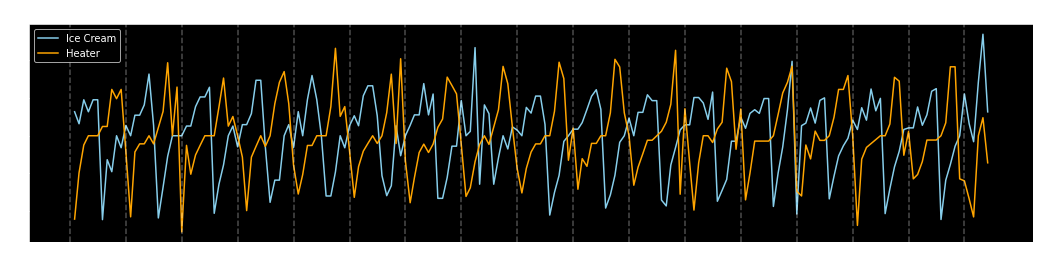

In [69]:
data_to_plot = iceHeat2_df

fg,ax = plt.subplots( figsize= (18,4) )

ax.plot( data_to_plot['ice_div_SD'], label= 'Ice Cream', color= 'skyblue' )
ax.plot( data_to_plot['heat_div_SD'], label= 'Heater', color= 'orange' )

[ ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.3 )\
  for e_yr in range( data_to_plot.index.min().year, data_to_plot.index.max().year+1 )  ];

ax.set_title( 'Data after removing heteroscedasticity', fontsize= 15 );  ax.legend(); plt.show()

#### ACF & PACF after removing varying variability

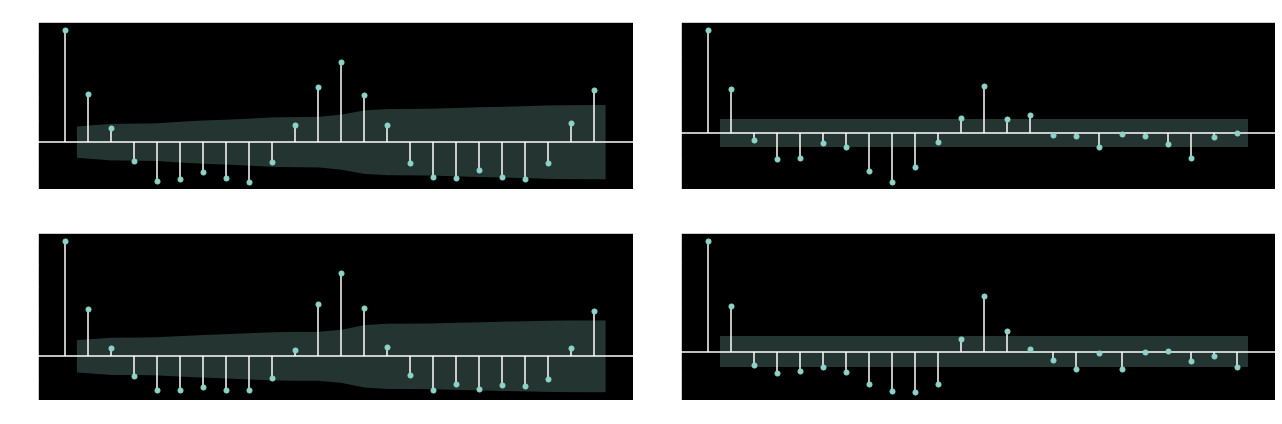

In [70]:
fg,ax = plt.subplots( 2,2, figsize= (18,3*2) )
plot_acf( data_to_plot['heat_div_SD'], ax= ax[0][0] )  ;  plot_pacf( data_to_plot['heat_div_SD'], ax= ax[0][1] )
plot_acf( data_to_plot['ice_div_SD'],  ax= ax[1][0] )  ;  plot_pacf( data_to_plot['ice_div_SD'],  ax= ax[1][1] )
plt.tight_layout(); plt.show()

#### Remove Seasonality

In [71]:
iceHeat2_df

heater  ice_cream  heat_norm_diff1  ice_norm_diff1  \
Month                                                            
2004-02-01      18         15        -0.918789        0.117140   
2004-03-01      14         16        -0.408351        0.058570   
2004-04-01      13         19        -0.102088        0.175710   
...            ...        ...              ...             ...   
2020-04-01      25         53         0.000000        0.527129   
2020-05-01      27         70         0.204175        0.995687   
2020-06-01      24         74        -0.306263        0.234279   

            heatNormDiff_std  iceNormDiff_std  heat_div_SD  ice_div_SD  
Month                                                                   
2004-02-01          0.415481         0.184201    -2.211387    0.635934  
2004-03-01          0.415481         0.184201    -0.982838    0.317967  
2004-04-01          0.415481         0.184201    -0.245710    0.953901  
...                      ...              ...          ...         ...  
2020-04-01          0.426657         0.369810     0.000000    1.425403  
2020-05-01          0.426657         0.369810     0.478547    2.692427  
2020-06-01          0.426657         0.369810    -0.717821    0.633512  

[197 rows x 8 columns]

In [72]:
iceHeat_MonthlyAvg_df = iceHeat2_df.groupby( by= iceHeat2_df.index.month ).mean()
iceHeat_MonthlyAvg_df

heater  ice_cream  heat_norm_diff1  ice_norm_diff1  \
Month                                                          
1      34.250000  25.375000        -0.197795        0.014642   
2      25.294118  26.117647        -0.870748        0.086132   
3      19.764706  29.470588        -0.564485        0.196381   
...          ...        ...              ...             ...   
10     26.937500  24.750000         0.906028       -0.300170   
11     34.250000  23.875000         0.746516       -0.051249   
12     36.187500  25.125000         0.197795        0.073212   

       heatNormDiff_std  iceNormDiff_std  heat_div_SD  ice_div_SD  
Month                                                              
1              0.580717         0.415976    -0.428360    0.130345  
2              0.570997         0.402342    -1.483129    0.250194  
3              0.570997         0.402342    -1.063595    0.433016  
...                 ...              ...          ...         ...  
10             0.580018         0.404376     1.613170   -0.830889  
11             0.580018         0.404376     1.183118   -0.088136  
12             0.580018         0.404376     0.491641    0.088998  

[12 rows x 8 columns]

In [73]:
iceHeat2_df['heat_monthly_avg'] =\
        iceHeat2_df.index.map( mapper= lambda df_index: iceHeat_MonthlyAvg_df.loc[df_index.month, 'heat_div_SD'] )

iceHeat2_df['ice_monthly_avg'] =\
        iceHeat2_df.index.map( mapper= lambda df_index: iceHeat_MonthlyAvg_df.loc[df_index.month, 'ice_div_SD'] )
iceHeat2_df

heater  ice_cream  heat_norm_diff1  ice_norm_diff1  \
Month                                                            
2004-02-01      18         15        -0.918789        0.117140   
2004-03-01      14         16        -0.408351        0.058570   
2004-04-01      13         19        -0.102088        0.175710   
...            ...        ...              ...             ...   
2020-04-01      25         53         0.000000        0.527129   
2020-05-01      27         70         0.204175        0.995687   
2020-06-01      24         74        -0.306263        0.234279   

            heatNormDiff_std  iceNormDiff_std  heat_div_SD  ice_div_SD  \
Month                                                                    
2004-02-01          0.415481         0.184201    -2.211387    0.635934   
2004-03-01          0.415481         0.184201    -0.982838    0.317967   
2004-04-01          0.415481         0.184201    -0.245710    0.953901   
...                      ...              ...          ...         ...   
2020-04-01          0.426657         0.369810     0.000000    1.425403   
2020-05-01          0.426657         0.369810     0.478547    2.692427   
2020-06-01          0.426657         0.369810    -0.717821    0.633512   

            heat_monthly_avg  ice_monthly_avg  
Month                                          
2004-02-01         -1.483129         0.250194  
2004-03-01         -1.063595         0.433016  
2004-04-01         -0.442926         0.838085  
...                      ...              ...  
2020-04-01         -0.442926         0.838085  
2020-05-01         -0.121663         0.967273  
2020-06-01         -0.128425         0.987311  

[197 rows x 10 columns]

In [74]:
iceHeat2_df['heat_div_SD__minus__heat_monthly'] = iceHeat2_df.heat_div_SD - iceHeat2_df.heat_monthly_avg
iceHeat2_df['ice_div_SD__minus__ice_monthly'] = iceHeat2_df.ice_div_SD - iceHeat2_df.ice_monthly_avg
iceHeat2_df

heater  ice_cream  heat_norm_diff1  ice_norm_diff1  \
Month                                                            
2004-02-01      18         15        -0.918789        0.117140   
2004-03-01      14         16        -0.408351        0.058570   
2004-04-01      13         19        -0.102088        0.175710   
...            ...        ...              ...             ...   
2020-04-01      25         53         0.000000        0.527129   
2020-05-01      27         70         0.204175        0.995687   
2020-06-01      24         74        -0.306263        0.234279   

            heatNormDiff_std  iceNormDiff_std  heat_div_SD  ice_div_SD  \
Month                                                                    
2004-02-01          0.415481         0.184201    -2.211387    0.635934   
2004-03-01          0.415481         0.184201    -0.982838    0.317967   
2004-04-01          0.415481         0.184201    -0.245710    0.953901   
...                      ...              ...          ...         ...   
2020-04-01          0.426657         0.369810     0.000000    1.425403   
2020-05-01          0.426657         0.369810     0.478547    2.692427   
2020-06-01          0.426657         0.369810    -0.717821    0.633512   

            heat_monthly_avg  ice_monthly_avg  \
Month                                           
2004-02-01         -1.483129         0.250194   
2004-03-01         -1.063595         0.433016   
2004-04-01         -0.442926         0.838085   
...                      ...              ...   
2020-04-01         -0.442926         0.838085   
2020-05-01         -0.121663         0.967273   
2020-06-01         -0.128425         0.987311   

            heat_div_SD__minus__heat_monthly  ice_div_SD__minus__ice_monthly  
Month                                                                         
2004-02-01                         -0.728257                        0.385740  
2004-03-01                          0.080757                       -0.115049  
2004-04-01                          0.197217                        0.115816  
...                                      ...                             ...  
2020-04-01                          0.442926                        0.587318  
2020-05-01                          0.600210                        1.725154  
2020-06-01                         -0.589396                       -0.353799  

[197 rows x 12 columns]

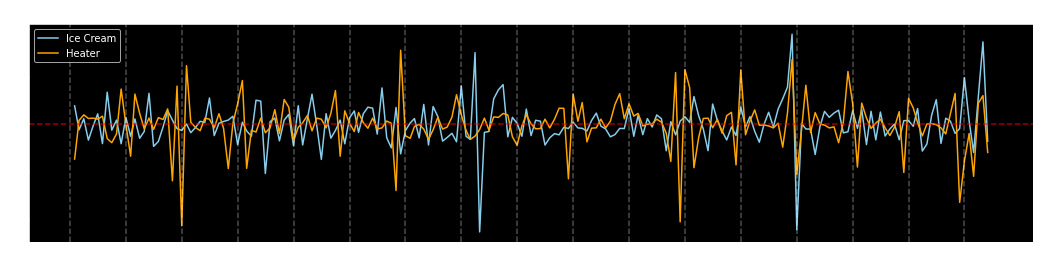

In [75]:
data_to_plot = iceHeat2_df
fg,ax = plt.subplots( figsize= (18,4) )

ax.plot( data_to_plot['ice_div_SD__minus__ice_monthly'], label= 'Ice Cream', color= 'skyblue' )
ax.plot( data_to_plot['heat_div_SD__minus__heat_monthly'], label= 'Heater', color= 'orange' )

[ ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.3 )\
  for e_yr in range( data_to_plot.index.min().year, data_to_plot.index.max().year+1 )  ];

ax.axhline( y= 0, linestyle= '--', color= 'red', alpha= 0.6)

ax.set_title( 'Data after removing Seasonality', fontsize= 15 );  ax.legend(); plt.show()

#### ACF & PACF after removing varying Seasonality

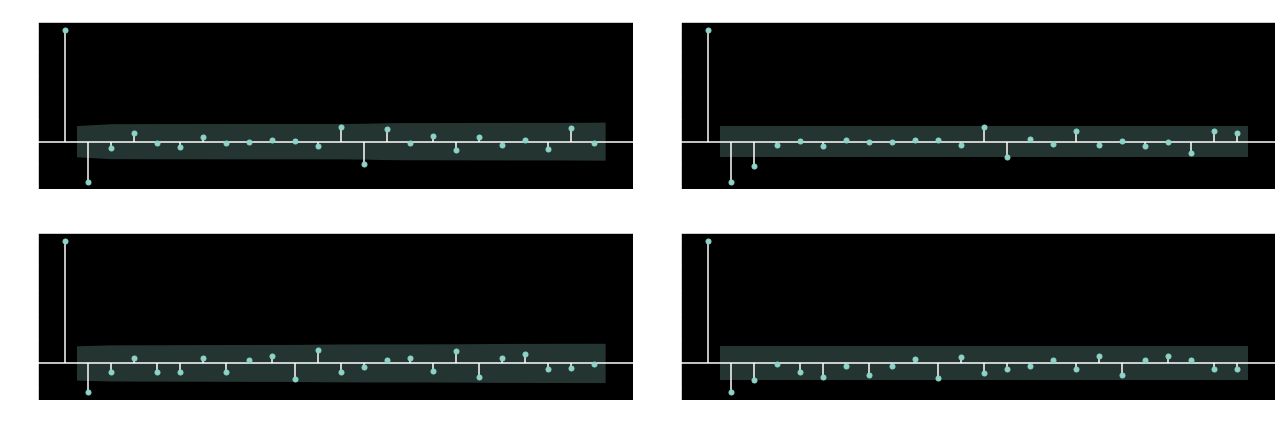

In [76]:
fg,ax = plt.subplots( 2,2, figsize= (18,3*2) )
plot_acf( data_to_plot['heat_div_SD__minus__heat_monthly'], ax= ax[0][0] );  plot_pacf( data_to_plot['heat_div_SD__minus__heat_monthly'], ax= ax[0][1] )
plot_acf( data_to_plot['ice_div_SD__minus__ice_monthly'],  ax= ax[1][0] ) ;  plot_pacf( data_to_plot['ice_div_SD__minus__ice_monthly'],  ax= ax[1][1] )
plt.tight_layout(); plt.show()

<h4>            
    
        There is no clear pattern in the ACF and PACF except the negative lag 1 autocorrelation in the ACF.
</h4>
<br>

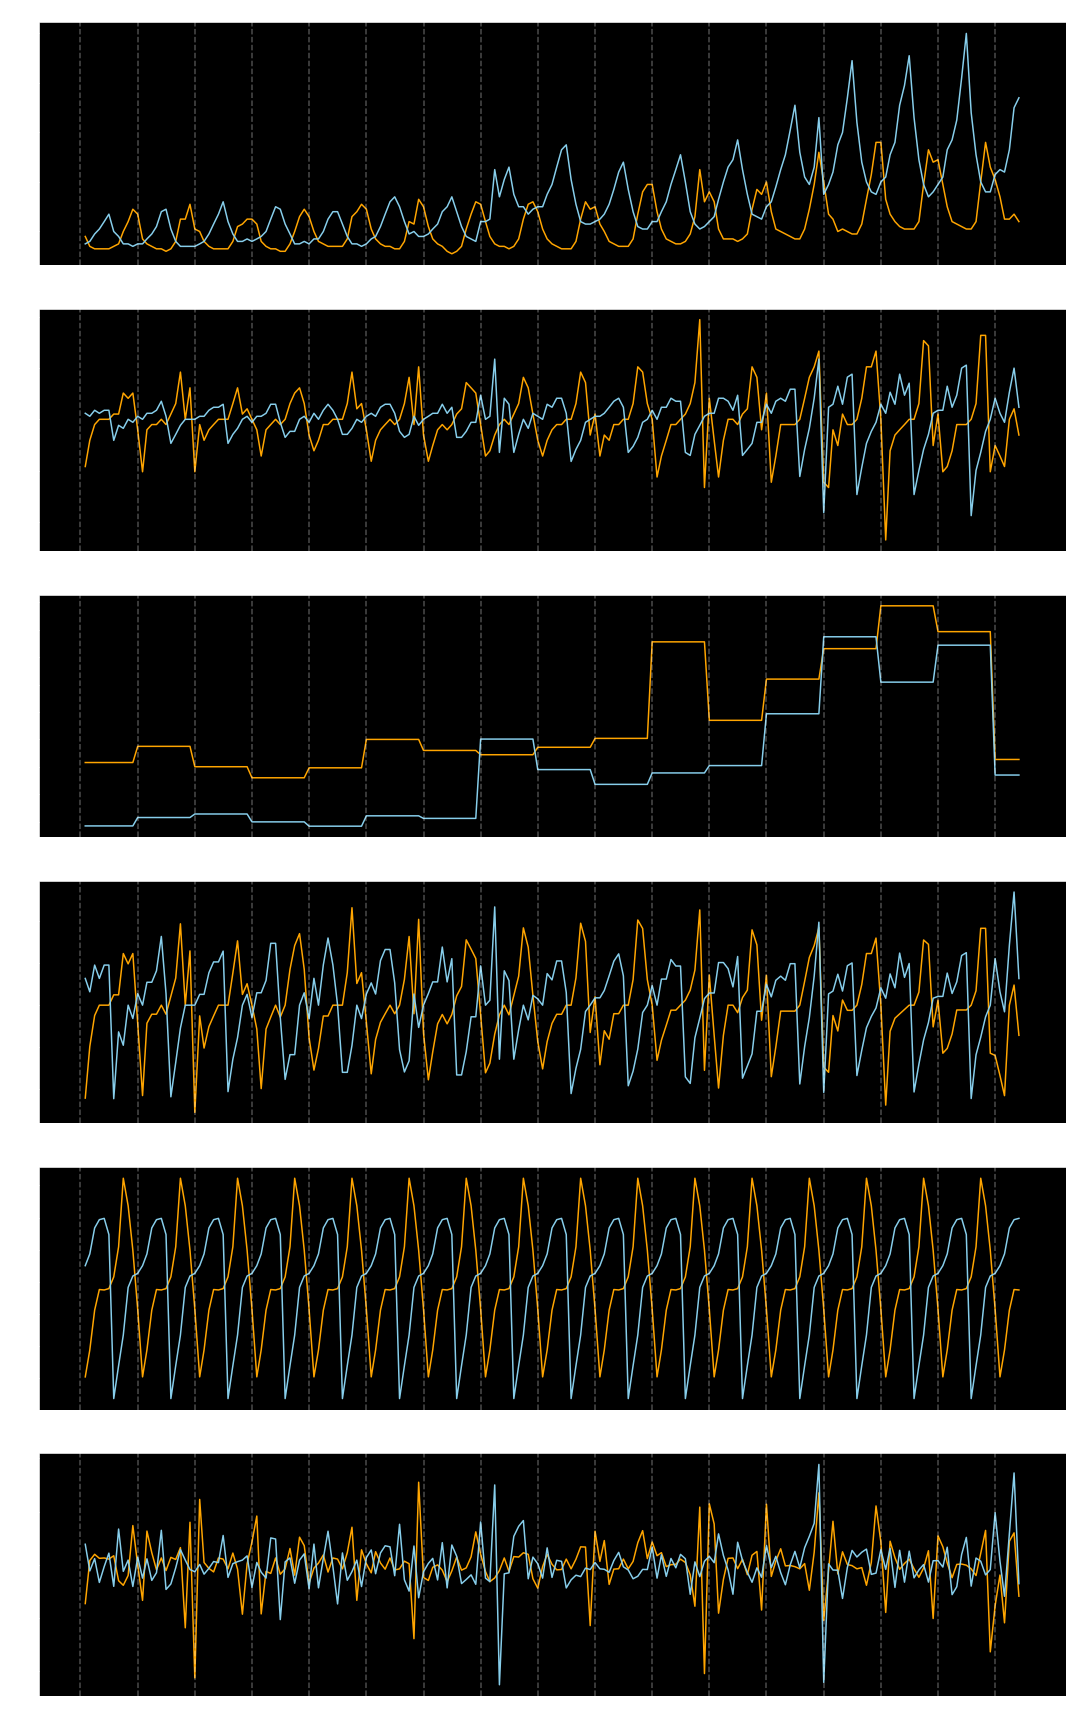

In [78]:
data_to_plot = iceHeat2_df
num_plots = len( data_to_plot.columns )//2

fg,ax = plt.subplots( nrows= num_plots, ncols= 1, figsize= (15,4*num_plots) )

col_num = 0
for e_I,e_ax in enumerate( ax.flatten() ):
    e_ax.plot( data_to_plot.iloc[:,col_num], label= 'Heater', color= 'orange' )
    e_ax.plot( data_to_plot.iloc[:,col_num+1], label= 'IceCream', color= 'skyblue' )
    e_ax.set_title( data_to_plot.columns[col_num] + '   &   ' + data_to_plot.columns[col_num+1]   )
    
    col_num += 2    

    [ e_ax.axvline( x= datetime.datetime(e_yr,1,1), linestyle= '--', alpha= 0.3 )\
      for e_yr in range( data_to_plot.index.min().year, data_to_plot.index.max().year+1 )  ];

plt.tight_layout()

<br>

### `PACF` - Heater

We are developing a model to predict `heater` considering `IceCream` as independent variable:
    
    heater = f (IceCream)
So we need to consider `lag` for the `heater` itself first by observing its `PACF` which becomes the `AR` order and <br>then we need to consider `lag` for the `IceCream`


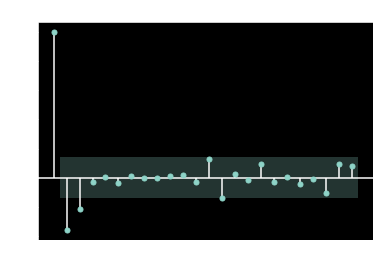

In [206]:
plot_pacf( iceHeat2_df['heat_div_SD__minus__heat_monthly'] ); plt.show()

Based on `Heater's PACF` consider `AR(2)` model

In [209]:
iceHeat2_df.head(2)

heater  ice_cream  heat_norm_diff1  ice_norm_diff1  \
Month                                                            
2004-02-01      18         15        -0.918789         0.11714   
2004-03-01      14         16        -0.408351         0.05857   

            heatNormDiff_std  iceNormDiff_std  heat_div_SD  ice_div_SD  \
Month                                                                    
2004-02-01          0.415481         0.184201    -2.211387    0.635934   
2004-03-01          0.415481         0.184201    -0.982838    0.317967   

            heat_monthly_avg  ice_monthly_avg  \
Month                                           
2004-02-01         -1.483129         0.250194   
2004-03-01         -1.063595         0.433016   

            heat_div_SD__minus__heat_monthly  ice_div_SD__minus__ice_monthly  
Month                                                                         
2004-02-01                         -0.728257                        0.385740  
2004-03-01                          0.080757                       -0.115049

#### Investigating Correlation between Heater & lagged IceCream (with different lag for IceCream)

In [267]:
for e_lag in range(1,20):
    
    heat_Series = iceHeat2_df['heat_div_SD__minus__heat_monthly'].iloc[ e_lag: ]
    ice_Series = iceHeat2_df['ice_div_SD__minus__ice_monthly'].iloc[ : -e_lag ]    
    
    corr_heat_iceLagd = scipy.stats.pearsonr( heat_Series,ice_Series )
    print('Correlation for Lag: {var1:2d}    ---->    Correlation = {var2:6.3f}, pvalue = {var3:5.3f}'\
           .format( var1=e_lag, var2= corr_heat_iceLagd[0], var3= corr_heat_iceLagd[1] )  )

Correlation for Lag:  1    ---->    Correlation = -0.032, pvalue = 0.661
Correlation for Lag:  2    ---->    Correlation = -0.099, pvalue = 0.170
Correlation for Lag:  3    ---->    Correlation = -0.002, pvalue = 0.980
Correlation for Lag:  4    ---->    Correlation =  0.060, pvalue = 0.405
Correlation for Lag:  5    ---->    Correlation = -0.054, pvalue = 0.457
Correlation for Lag:  6    ---->    Correlation =  0.065, pvalue = 0.375
Correlation for Lag:  7    ---->    Correlation = -0.049, pvalue = 0.498
Correlation for Lag:  8    ---->    Correlation =  0.079, pvalue = 0.280
Correlation for Lag:  9    ---->    Correlation = -0.053, pvalue = 0.468
Correlation for Lag: 10    ---->    Correlation =  0.030, pvalue = 0.688
Correlation for Lag: 11    ---->    Correlation = -0.060, pvalue = 0.418
Correlation for Lag: 12    ---->    Correlation = -0.075, pvalue = 0.309
Correlation for Lag: 13    ---->    Correlation =  0.198, pvalue = 0.007
Correlation for Lag: 14    ---->    Correlation = -

In [ ]:
# different print format syntax

#     print( f'Correlation for Lag: %2d    ---->    Correlation = %5.2f, pvalue = %5.3f'\
#            %( e_lag, corr_heat_iceLagd[0], corr_heat_iceLagd[1] )                     )
    
#     print( heat_Series.index[0:10], '\n', ice_Series.index[0:10],'\n\n' )

#### `VAR` model fit

In [275]:
iceHeat_XY_df = iceHeat2_df[ ['heat_div_SD__minus__heat_monthly', 'ice_div_SD__minus__ice_monthly'] ]
iceHeat_XY_df.head(3)

heat_div_SD__minus__heat_monthly  ice_div_SD__minus__ice_monthly
Month                                                                       
2004-02-01                         -0.728257                        0.385740
2004-03-01                          0.080757                       -0.115049
2004-04-01                          0.197217                        0.115816

In [274]:
varModel_fit = VAR( iceHeat_XY_df ).fit( maxlags= 13 )
varModel_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 05, Jun, 2021
Time:                     13:56:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.92349
Nobs:                     184.000    HQIC:                  -2.48459
Log likelihood:          -204.405    FPE:                  0.0571123
AIC:                     -2.86700    Det(Omega_mle):       0.0434311
--------------------------------------------------------------------
Results for equation heat_div_SD__minus__heat_monthly
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                        0.005855         0.036062            0.162           0.871
L1.heat_div_SD__minus__heat_monthly         -

Here we are considering:    `heater = f (IceCream)` <br>
so in the summary, let's only consider <b><i>Results for equation heat_div_SD__minus__heat_monthly</i></b>. Now here only considering those lags where: &ensp;&ensp;&ensp; `pValue < 0.05`; in this case, it is lag: 1 & 2 of `Heater` and lag: 13 of `IceCream`

<h3><p style= 'text-align:center;'>VA model lags selection based on pValue</p></h3>
<img src= 'images/VA_model_lags_selection.png' style= 'width:941px;height:302px;'>

<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

Thus our final model is:
$$
\hat{H}_t = - 0.41 H_{t-1} - 0.19H_{t-2} + 0.2I_{t-13}
$$    

<br>

### `Granger Causality` Model

In [283]:
from statsmodels.tsa.stattools import grangercausalitytests

#### simulate data

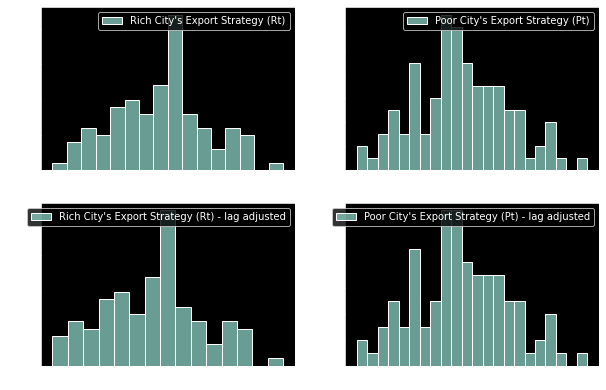

Pt        Rt
0   0.151415  0.113253
1   0.151913  0.093458
2   0.072465  0.112355
..       ...       ...
97  0.091716  0.058363
98  0.083372  0.073272
99  0.059242  0.114321

[100 rows x 2 columns]

In [460]:
## building data for simple AR(1)

# build the Rt (Rich City's Export Strategy)
µ = 0.5
Rt = [  0.1 * np.random.normal()  ]
Rt = [  µ*Rt[-1] + 0.1*np.random.normal() for _ in range(106)  ]

# build the timeSeries (Pt: Poor City's Export Strategy) data that is 'Granger Caused' by Rt
Pt = [  e_elem + 0.1*np.random.normal() for e_elem in Rt  ]

# adjust the lag by shifting it by 3 unit of time in the simu data
Rt_ori, Pt_ori = Rt, Pt

shifted_tm = 3
Rt, Pt = Rt[ shifted_tm : ],  Pt[ : -shifted_tm ]

# plots the simu data
fg, ax = plt.subplots( 2,2, figsize= (10,2*3.3) )
sns.histplot( data= Rt_ori, binwidth=0.03, ax= ax[0][0], label= "Rich City's Export Strategy (Rt)" )
sns.histplot( data= Pt_ori, binwidth=0.03, ax= ax[0][1], label= "Poor City's Export Strategy (Pt)" )
sns.histplot( data= Rt, binwidth=0.03, ax= ax[1][0], label= "Rich City's Export Strategy (Rt) - lag adjusted" )
sns.histplot( data= Pt, binwidth=0.03, ax= ax[1][1], label= "Poor City's Export Strategy (Pt) - lag adjusted" )

[ e_Ax.legend() for e_Ax in ax.flatten() ];  plt.show()

# combining Pt & Rt in df in this order
PtRt_df = pd.DataFrame( data= zip(Pt,Rt), columns= ['Pt','Rt'] )

PtRt_df = PtRt_df.rolling( window= 4 ).mean().dropna()
PtRt_df.reset_index( drop= True, inplace= True )
PtRt_df

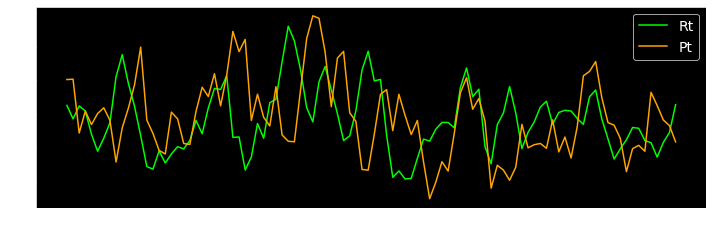

In [461]:
fg,ax = plt.subplots( figsize= (12,3.7) )

ax.plot( PtRt_df['Rt'], color= 'lime' )
ax.plot( PtRt_df['Pt'], color= 'orange' )
ax.legend( ['Rt','Pt'], fontsize= 14 )
plt.show();

#### Granger Causality model fit

In [462]:
gcModel_fit = grangercausalitytests( x= PtRt_df, maxlag= 4, addconst= True )


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6071  , p=0.0042  , df_denom=96, df_num=1
ssr based chi2 test:   chi2=8.8761  , p=0.0029  , df=1
likelihood ratio test: chi2=8.5005  , p=0.0036  , df=1
parameter F test:         F=8.6071  , p=0.0042  , df_denom=96, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4824  , p=0.0056  , df_denom=93, df_num=2
ssr based chi2 test:   chi2=11.5544 , p=0.0031  , df=2
likelihood ratio test: chi2=10.9224 , p=0.0042  , df=2
parameter F test:         F=5.4824  , p=0.0056  , df_denom=93, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.1977  , p=0.0000  , df_denom=90, df_num=3
ssr based chi2 test:   chi2=29.7392 , p=0.0000  , df=3
likelihood ratio test: chi2=25.9398 , p=0.0000  , df=3
parameter F test:         F=9.1977  , p=0.0000  , df_denom=90, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.4804 , p=0.0000  , df_d

<br>
<h2>Modeling work</h2>
</div>
       
    - Dickey-Fuller & Augmented Dickey-Fuller test for Stationarity check
    - Transforming of TimeSeries data from non-Stationary into Stationary
    - Experimenting & modeling with different AR order
    - AIC & BIC criteria
    - Un-Transforming of TimeSeries data from Stationary to non-Stationary


### Dickey-Fuller Test

In [634]:
from statsmodels.tsa.stattools import adfuller

#### data

In [678]:
# udf to generate AR simulated data

def genr_ARsimuData( p, φ, sample_length ):
    '''
    p = order of AR model  |   φ = coefficient   |   length = 
    '''
    # cast coeff to np array
    coeff = np.array( φ )
    
    simuData = [ np.random.normal() for _ in range(p) ]
    
    for _ in range( sample_length ):
        prev_Simu_val  = np.array(  simuData[ -p: ][ ::-1 ]  )          # reversed simuData

        new_Simu_val   = np.sum( prev_Simu_val*φ )  +   np.random.normal()

        simuData.append( new_Simu_val )
    
    return( np.array(simuData) )

#### Generate timeSeries with Stationary data (i.e. `Stationary AR` process)   i.e.  ` φ < 1 `

ADF Statistic (tValue): -6.38        |          pValue: 0.00


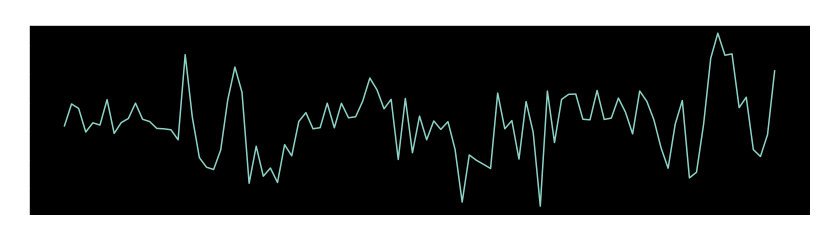

In [696]:
simuData1 = genr_ARsimuData( p= 1, φ= 0.5, sample_length= 100 )

# Aug Dickey-Fuller test
adfuller_test( simuData1 )

fg,ax = plt.subplots( figsize= (14,3.5) )
ax.plot( simuData1 )
ax.set_title( 'Stationary AR(1) simulated data', fontsize= 16 )
plt.show()

#### Generate timeSeries with non-Stationary data (i.e. `Non-Stationary AR` process) i.e.  ` φ = 1 `

ADF Statistic (tValue): -0.38        |          pValue: 0.91


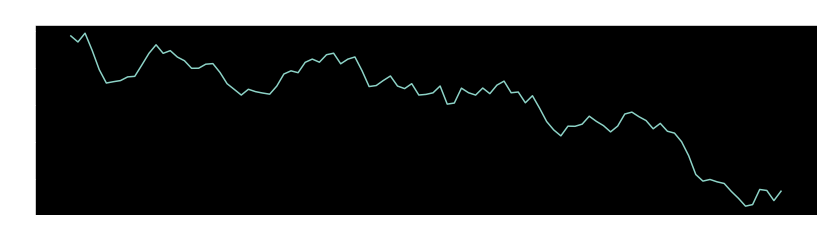

In [698]:
simuData2 = genr_ARsimuData( p= 1, φ= 1, sample_length= 100 )

adfuller_test(simuData2)

fg,ax = plt.subplots( figsize= (14,3.5) )
ax.plot( simuData2 )
ax.set_title( 'Non-Stationary AR(1) process', fontsize= 16 )
plt.show()

#### Generate timeSeries with Stationary data (i.e. `Stationary AR` process) i.e.  ` φ1 + φ2 < 1  ` 

ADF Statistic (tValue): -4.74        |          pValue: 0.00


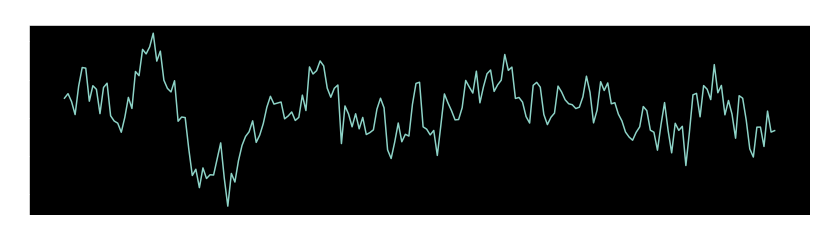

In [708]:
simuData2 = genr_ARsimuData( p= 1, φ= [0.5,0.3], sample_length= 200 )

adfuller_test(simuData2)

fg,ax = plt.subplots( figsize= (14,3.5) )
ax.plot( simuData2 )
ax.set_title( 'Stationary AR(2) process', fontsize= 16 )
plt.show()

#### Generate timeSeries with non-Stationary data (i.e. `Non Stationary AR` process) i.e.  ` φ1 +  φ2 = 1  ` 

ADF Statistic (tValue): -2.99        |          pValue: 0.04


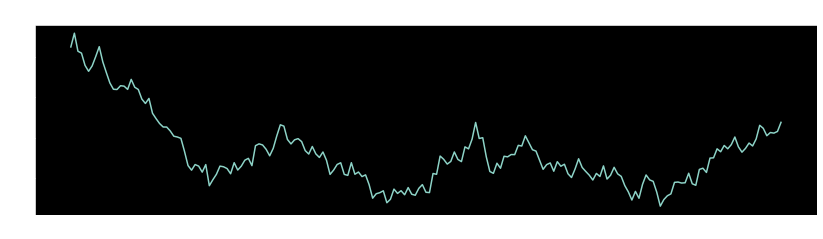

In [710]:
simuData2 = genr_ARsimuData( p= 1, φ= [0.75,0.25], sample_length= 200 )

adfuller_test(simuData2)

fg,ax = plt.subplots( figsize= (14,3.5) )
ax.plot( simuData2 )
ax.set_title( 'Non-Stationary AR(2) process', fontsize= 16 ); plt.show()

<br>

## Transforming data into Stationary

#### parsing data using func

In [673]:
def dt_parser_func(dt_str):
    return( datetime.datetime.strptime( dt_str, '%Y-%m-%d' ) )

def adfuller_test( ser ):
    adfuller_tests_result = adfuller( ser )
    print( 'ADF Statistic (tValue): {var1:5.2f}        |          pValue: {var2:4.2f}'\
           .format( var1=adfuller_tests_result[0], var2= adfuller_tests_result[1] )  )
    return(  [ np.round(adfuller_tests_result[0],3), np.round(adfuller_tests_result[1],3) ] )

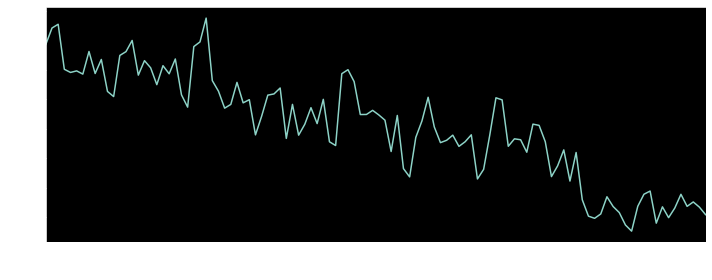

Date
2004-01-01    27140
2004-02-01    28526
2004-03-01    28845
              ...  
2012-10-01    13795
2012-11-01    13352
2012-12-01    12716
Freq: MS, Name: Total, Length: 108, dtype: int64


In [591]:
catfsh_Ser = pd.read_csv( 'datasets/catfish.csv', parse_dates= [0], index_col= 0, squeeze= True )  # OR

catfsh_Ser = pd.read_csv( 'datasets/catfish.csv', parse_dates= ['Date'], date_parser= dt_parser_func,
                          index_col= 'Date', squeeze= True )                                           

# infer the frequency of the data
catfsh_Ser = catfsh_Ser.asfreq( freq= pd.infer_freq(catfsh_Ser.index) )

catfsh_Ser = catfsh_Ser.loc[ datetime.datetime(2004,1,1): ]

catfsh_Ser.plot( figsize= (10,4) ); plt.tight_layout(); plt.show()

print( catfsh_Ser )

#### Stationarity check 

In [592]:
adfuller_test( catfsh_Ser )

ADF Statistic (tValue): -0.38        |          pValue: 0.91


[-0.383, 0.913]

Since pValue > 0.05, it is not Stationary

#### Making the data Stationary by taking 1st difference

ADF Statistic (tValue): -2.17        |          pValue: 0.22


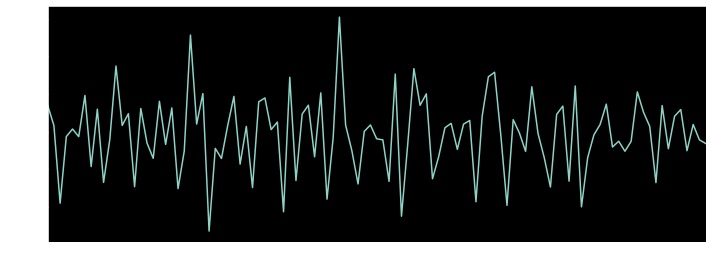

In [593]:
catfsh_1stDiff_Ser = catfsh_Ser.diff().dropna()

adfuller_test( catfsh_1stDiff_Ser )

catfsh_1stDiff_Ser.plot( figsize= (10,4) ); plt.tight_layout(); plt.show()

#### Making the data Stationary by taking 2nd difference

ADF Statistic (tValue): -7.16        |          pValue: 0.00


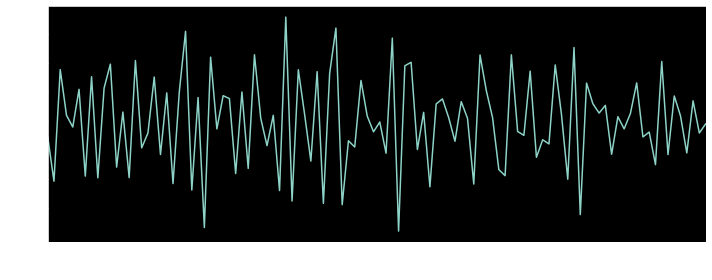

In [597]:
catfsh_2ndDiff_Ser = catfsh_Ser.diff().diff().dropna()

adfuller_test( catfsh_2ndDiff_Ser )

catfsh_2ndDiff_Ser.plot( figsize= (10,4) ); plt.tight_layout(); plt.show()

#### `PACF` to consider order of AR model's order

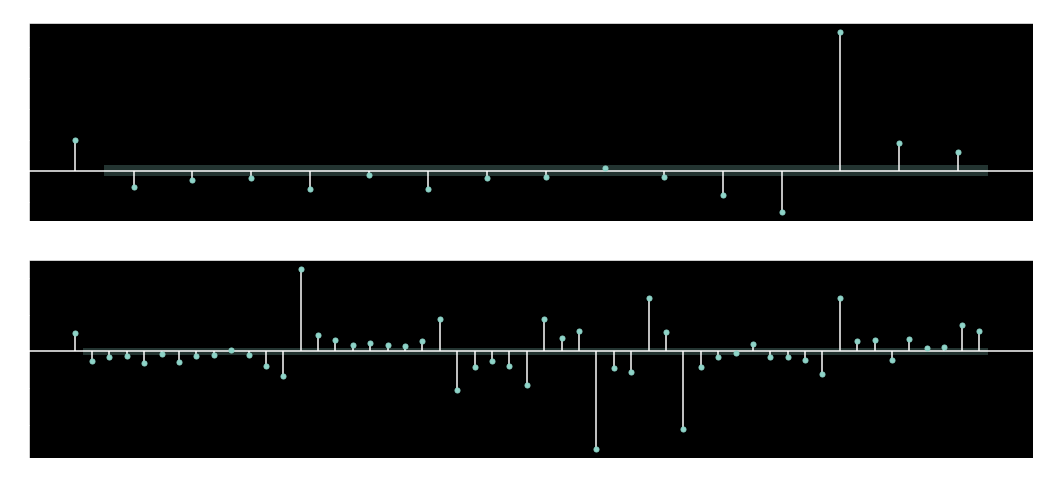

In [598]:
warnings.filterwarnings( action= 'ignore' )

fg,ax = plt.subplots( 2,1, figsize= (18,8) )

plot_pacf( catfsh_2ndDiff_Ser, lags= 15, ax= ax[0] )
plot_pacf( catfsh_2ndDiff_Ser, lags= len(catfsh_2ndDiff_Ser)//2-1, ax= ax[1] )

set_ticks_for_axes( ax_ls= ax, minor_major= (1,5) )
plt.show()

<br>

## `AR` model fit selection criteria: `AIC` & `BIC`

Based on the above `PACF`, we will try for various combination of AR model: &ensp; `1, 4, 6, 10, 11`

<br>

### `AIC` & `BIC`
#### Each model has: 

    - a log likelihood (L)
    - a number of parameters (k)
    - a number of samples used for fitting (n)

#### AIC &ensp; = &ensp; 2 &thinsp; k &thinsp; - &thinsp;  2 &thinsp; L
<b>⬇</b> AIC via <b>⬆</b> log likelihood and/or <b>⬇</b> parameters

#### BIC &ensp; = &ensp;  ln(n) &thinsp; k &thinsp; - &thinsp; 2 &thinsp;L
<b>⬇</b> BIC via <b>⬆</b> log likelihood and/or <b>⬇</b> parameters and/or <b>⬇</b> samples used in fitting

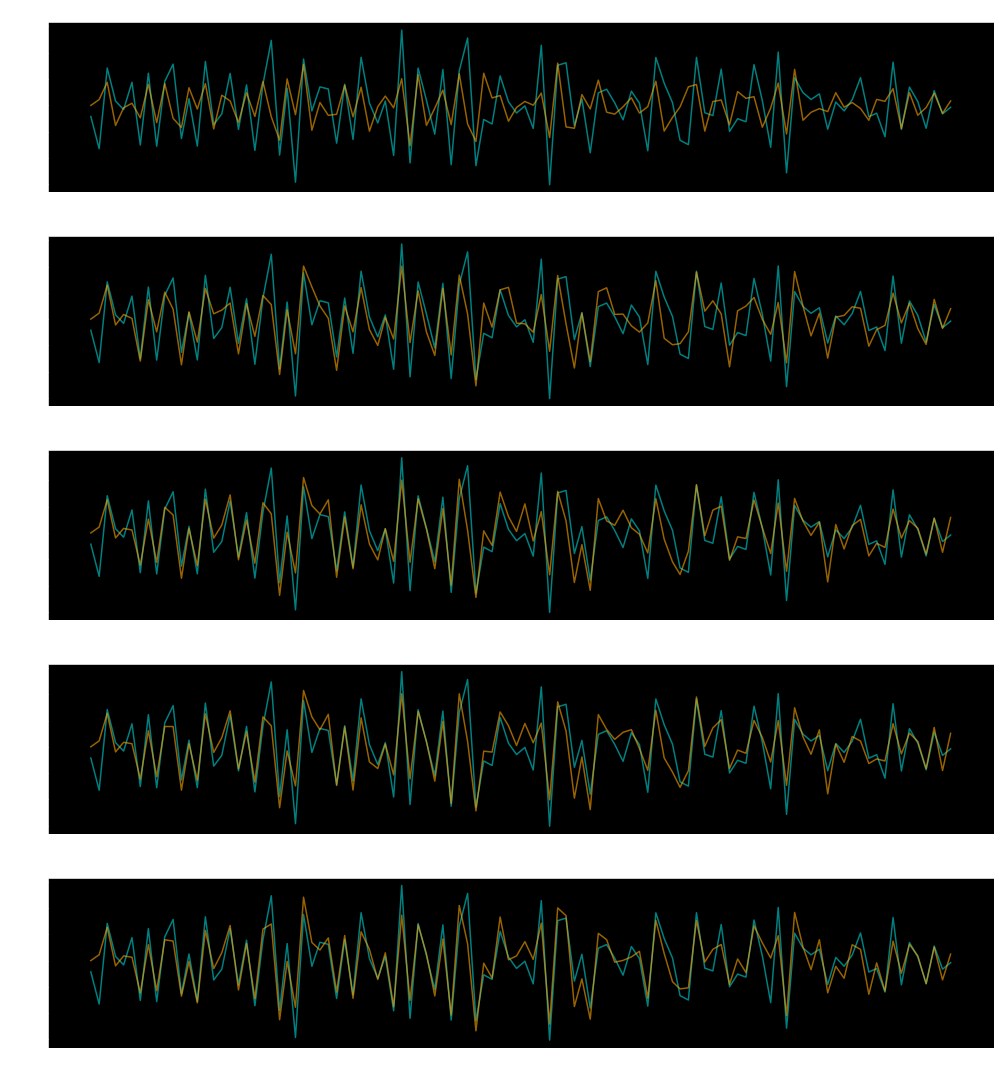

In [628]:
order_ls = [ 1,4,6,10,11 ]

fg,ax = plt.subplots( nrows= len(order_ls), ncols= 1, figsize= ( 14,3*len(order_ls) ) )

arModel_fit_dict = {}

for idx, (e_order,e_ax) in enumerate(  zip( order_ls,ax.flatten() )  ):
    
    arModel_fit_dict[e_order] = ARMA( catfsh_2ndDiff_Ser, order= (e_order,0) ).fit()
    
    e_ax.plot(  catfsh_2ndDiff_Ser, color= 'teal'  )
    e_ax.plot(  arModel_fit_dict[e_order].fittedvalues, color= 'orange', alpha= 0.6  )
    
    e_ax.set_title(  'AR(%d) model   |   AIC = %5.2f   |   BIC = %5.2f'%\
                          (e_order,arModel_fit_dict[e_order].aic,arModel_fit_dict[e_order].bic ),
                   fontsize= 12  )
    
plt.tight_layout()

We will choose model with lowest `AIC` & `BIC`. In cour case, we choose model with `AR(11)`.

<br>

## Reverse Transforming Stationary into non-Stationary

#### Steps:

(0) Original Series: $y_t$

(a) Normalize ($y_t) \rightarrow  n_t = \frac{y_t - \mu}{\sigma}$

(b) Exponentiate ($n_t) \rightarrow$  $a_t = e^{n_t}  =  e^{\frac{y_t - \mu}{\sigma}} $

(c) First Difference ($a_t)\rightarrow$ $∆a_t = a_t - a_{t-1} = e^{n_t} - e^{n_{t-1}}$ <br><br>
    &emsp;Final version (in-terms of y): &emsp;&emsp;
    $z_t = ∆a_t = e^{\frac{y_t - \mu}{\sigma}} - e^{\frac{y_{t-1} - \mu}{\sigma}}$ <br><br>
    &emsp; &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
     $z_t = e^{\frac{y_t - \mu}{\sigma}} - e^{\frac{y_{t-1} - \mu}{\sigma}}$
    

<br>

#### &emsp; Normalize: &emsp; $y_t \rightarrow  n_t = \frac{y_t - \mu}{\sigma}$

In [ ]:
def normalize_func( col ):
    normzd = ( col - col.mean() ) / col.std()
    return(normzd)

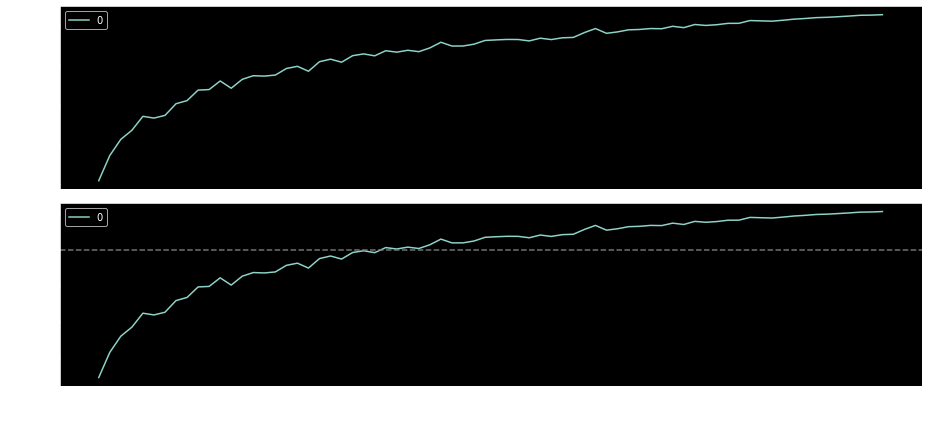

In [850]:
yt = pd.read_csv( 'datasets/original_timeSeries_data.csv' )

nt = yt.apply( func= normalize_func )

fg,ax = plt.subplots( 2,1, figsize= (13,6), sharex= True )
yt.plot( ax= ax[0] );  nt.plot( ax= ax[1] )
ax[1].axhline( y= 0, linestyle= '--', alpha= 0.9, color= 'gray' )
ax[0].set(  xlabel= 'Hours Since Published', ylabel= 'Views (yt)' )
ax[1].set(  xlabel= 'Hours Since Published', ylabel= 'Normalized Views (nt)' )

set_Xticks_for_axes( ax_ls= ax, minor_major= (6,12) )

plt.tight_layout()

#### &emsp; Exponentiate: &emsp; $n_t \rightarrow$  $a_t = e^{n_t}  =  e^{\frac{y_t - \mu}{\sigma}} $

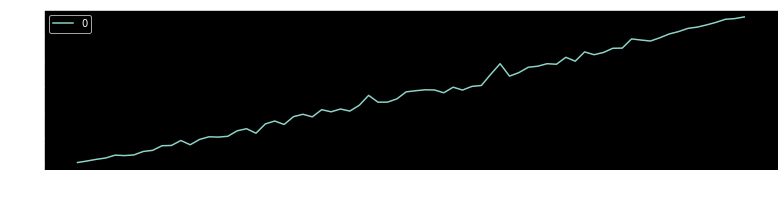

In [851]:
at = np.exp( nt )

data_to_plt = at

fg,ax = plt.subplots( 1,1, figsize= (11,3) )
data_to_plt.plot( ax= ax )
ax.set(  xlabel= 'Hours Since Published', ylabel= 'Exp Normzd Views (at)' )
plt.tight_layout()

In [852]:
# Dickey-Fuller test for statn
adfuller_test( at );         # --> Not statn

ADF Statistic (tValue):  1.55        |          pValue: 1.00


####  &emsp; First Difference: &emsp;   $z_t = ∆a_t = e^{\frac{y_t - \mu}{\sigma}} - e^{\frac{y_{t-1} - \mu}{\sigma}}$

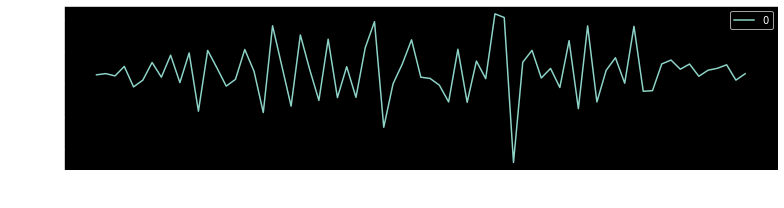

In [853]:
zt = at.diff().dropna()

data_to_plt = zt

fg,ax = plt.subplots( 1,1, figsize= (11,3) )
data_to_plt.plot( ax= ax )
ax.set(  xlabel= 'Hours Since Published', ylabel= '1st diff \n Exp Normzd Views (zt)' )
plt.tight_layout()

In [854]:
# Dickey-Fuller test for statn
adfuller_test( zt );         # --> Statn

ADF Statistic (tValue): -4.92        |          pValue: 0.00


<br>

### Fit `AR` model

#### `PACF` & `ACF`

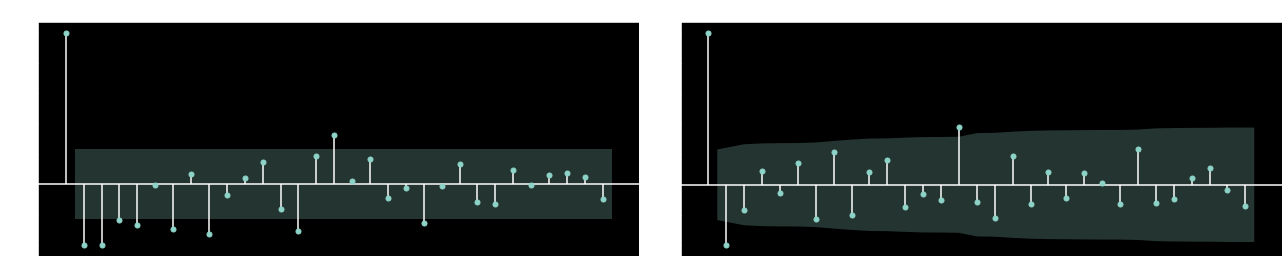

In [857]:
fg,ax = plt.subplots( 1,2, figsize= (18,4) )

plot_pacf( zt, lags= 30 , ax= ax[0] );             plot_acf( zt, lags= 30 , ax= ax[1])

set_Xticks_for_axes( ax_ls= ax, minor_major= (1,5) )
plt.tight_layout()

In [800]:
# model creat & fit

armaModel_fit = ARMA( zt, order= (4,1) ).fit()

# print( armaModel_fit.summary() )

In [829]:
# predict 3 hours

step_num = 5
zhat_ary = armaModel_fit.forecast( steps= step_num )

display( zhat_ary )

zhat = zhat_ary[0]
zhat_lowerCI = zhat_ary[2][:,0]
zhat_upperCI = zhat_ary[2][:,1]

print( f' zhat = {zhat}, \n zhat_lowerCI= {zhat_lowerCI}, \n zhat_upperCI = {zhat_upperCI}' )

(array([0.04562219, 0.04090558, 0.04115992, 0.0409558 , 0.04023129]),
 array([0.06324201, 0.07895416, 0.07975093, 0.08015158, 0.08016326]),
 array([[-0.07832987,  0.16957426],
        [-0.11384172,  0.19565288],
        [-0.11514904,  0.19746887],
        [-0.11613841,  0.19805001],
        [-0.11688581,  0.1973484 ]]))

 zhat = [0.04562219 0.04090558 0.04115992 0.0409558  0.04023129], 
 zhat_lowerCI= [-0.07832987 -0.11384172 -0.11514904 -0.11613841 -0.11688581], 
 zhat_upperCI = [0.16957426 0.19565288 0.19746887 0.19805001 0.1973484 ]


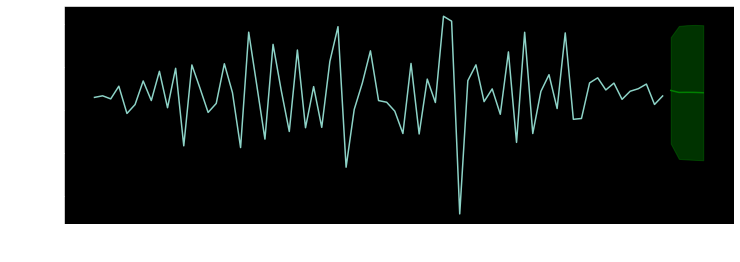

In [858]:
fg,ax = plt.subplots( figsize= (12,4) )

ax.plot( zt )

ax.set(  xlabel= 'Hours Since Published', ylabel= '1st diff Exp \n Normzd Views (zt)' )

ax.plot(  np.arange( len(zt)+1, len(zt)+step_num+1 ), zhat, color='g'  )
ax.fill_between( x= np.arange( len(zt)+1, len(zt)+step_num+1 ),
                 y2= zhat_lowerCI, y1= zhat_upperCI, color='g', alpha= 0.4 )

plt.show()

### Reverse Transformation

In [865]:
def reverse_transform( zhat, yt, µ,σ ):    
    from numpy import log as ln, exp as e
    
    yhat = [   µ + σ*ln(  zhat[0] + e((yt.iloc[-1]-µ)/σ)  )   ]            # <-- 1st prediction
    
    for i in range( len(zhat[1:]) ):                                       # <--  for successive next predictions
        yhat_i  =  µ + σ*ln(  zhat[i+1] + e((yhat[-1]-µ)/σ)  )
        yhat.append( yhat_i )
    
    return( np.array(yhat).flatten() ) 

In [879]:
mu, sigma = yt.mean()[0],yt.std()[0]

yhat = reverse_transform( zhat, yt, μ= yt.mean()[0], σ= yt.std()[0] )
yhat_lower_CI = reverse_transform( zhat_lowerCI, yt, μ= mu, σ= sigma )
yhat_upper_CI = reverse_transform( zhat_upperCI, yt, μ= mu, σ= sigma )

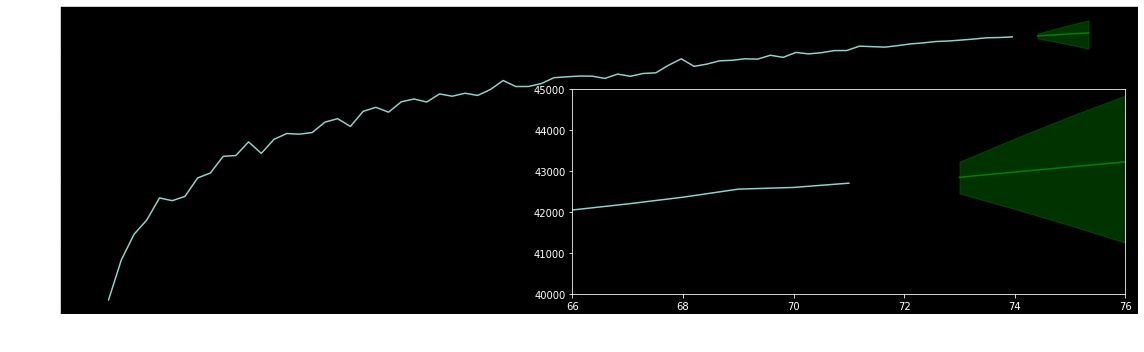

In [930]:
## main plot

fg,ax1 = plt.subplots( figsize= (16,5) )

ax1.plot( yt )
ax1.plot(  np.arange( len(yt)+1, len(yt)+step_num+1 ), yhat, color= 'g' )

ax1.fill_between( x= np.arange( len(yt)+1, len(yt)+step_num+1 ),
                  y2= yhat_lower_CI, y1= yhat_upper_CI, color='g', alpha= 0.4 )

ax1.set(  xlabel= 'Hours Since Published', ylabel= 'Views (yt)' )

## inset zoomed plot

ax2 = fg.add_axes( [.5,.17,.48,.57] )

ax2.plot( yt )
ax2.plot(  np.arange( len(yt)+1, len(yt)+step_num+1 ), yhat, color= 'g'  )

ax2.fill_between( x= np.arange( len(yt)+1, len(yt)+step_num+1 ),
                 y2= yhat_lower_CI, y1= yhat_upper_CI, color='g', alpha= 0.4 )
# main code for zooming
plt.xlim( 66,76 ); plt.ylim( 40000,45000 )

plt.tight_layout(); plt.show()

### Libraries

In [3]:
# %reset
# import utility_madhur



#   &thinsp;   &nbsp;   &ensp;   &emsp;

#  import warnings; warnings.filterwarnings( action= 'ignore' )

# # to check whether a string is a python keyword
# import keyword
# keyword.iskeyword('str')

from IPython.core.display import display, HTML
display(  HTML( '<style>.container { width:100% !important; }</style>' )  )

import warnings
get_ipython().run_line_magic('config', 'Completer.use_jedi = False')
import os, random, time

import pandas as pd
# import pandas_datareader as pdr
import numpy as np,  seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn
import missingno as msno
import h5py, math, scipy, statsmodels
# import xlrd
import ipywidgets as widgets

import datetime, dateutil
from datetime import timedelta


# import fuzzywuzzy
# from fuzzywuzzy import fuzz, process
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.gridspec import GridSpec
from pylab import rcParams

# plt.style.use('Solarize_Light2')
plt.style.use('dark_background')

from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller
from statsmodels.tsa import seasonal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa import arima_model, arima_process, arima
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from arch import arch_model
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

import pmdarima as pm
import joblib

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# import yfinance as yf

get_ipython().run_line_magic('matplotlib', 'inline')

np.random.seed(1) # set a seed so that the results are consistent

## Set Jupyter notebook display options for pandas

pd.set_option('display.max_columns', None)
# pd.options.display.max_columns = 8
# pd.set_option('display.max_rows', None)
pd.options.display.max_rows = 5

# <h3><p style= 'text-align:center;'>Img title</p></h3>
# <img src= 'images/split-apply-combine.png' style= 'width:917px;height:437px;'>

# m, wd, ht = 2, 990, 576; ( wd/m, ht/m  )


In [2]:
import re

def clean_text(str_var):    

    '''
    clean the text, useful for column header
    Arguments:
    str_var -- a string variable of any size

    Return:
    str_modf -- a cleaned string variable
    
    '''
    
    # lower case and revome begin & end space
    str_modf = str_var.lower().strip()    
    # replace all non word chars ( everything except letters and nos )
    str_modf = re.sub( pattern= r'[^\w\s]', repl= '_', string= str_modf )    
    # replace all runs of whitespace with '_'
    str_modf = re.sub( pattern= r'\s+', repl= '_', string= str_modf )    
    # repalce > 1 consecutive '_'
    str_modf = re.sub( pattern= r'[__]+', repl= '_', string= str_modf )   
    
    # remove begining and trailing _ : '__any_word____' --> 'any_word'
    def _remove_begin_end_(str_var):
        while True:
            if str_var[-1] == '_':
                str_var = str_modf[:len(str_modf)-1]
            else:                
                break                
        while True:
            if str_var[0] == '_':                            
                str_var = str_modf[1:len(str_modf)]
            else:                
                break                
        return(str_var)
    
    str_modf = _remove_begin_end_(str_modf)        
    
    return(str_modf)    

clean_colm_name = lambda df: [ clean_text(e_cNm) for e_cNm in df.columns ]

def set_Xticks_for_axes( ax_ls, minor_major = (10,50) ):
    '''
    sets the x axis' major & minor ticks distance
    ax = the axis obj, could be single ax obj, a list of axis objs, np array of axis objs
    minor_major = tuple for major and minor distance for x axis    
    '''
    from matplotlib.ticker import ( MultipleLocator, AutoMinorLocator )

    for e_ax in np.array(ax_ls).flatten():      #<-- making all list or single ax obj into np.array & then flattening it
        e_ax.xaxis.set_minor_locator( MultipleLocator( minor_major[0] ) )
        e_ax.xaxis.set_major_locator( MultipleLocator( minor_major[1] ) )
        
def set_ticks_for_axes( ax_ls, x_y= 'x', minor_major= (10,50) ):
    '''
    sets the x axis' major & minor ticks distance
    x_y = the x or y axis
    ax = the axis obj, could be single ax obj, a list of axis objs, np array of axis objs
    minor_major = tuple for major and minor distance for x axis    
    '''
    from matplotlib.ticker import ( MultipleLocator, AutoMinorLocator )
    
    if x_y == 'x' or x_y != 'y':
        for e_ax in np.array(ax_ls).flatten():      #<-- making all list or single ax obj into np.array & then flattening it
            e_ax.xaxis.set_minor_locator( MultipleLocator( minor_major[0] ) )
            e_ax.xaxis.set_major_locator( MultipleLocator( minor_major[1] ) )
    elif x_y == 'y':
        for e_ax in np.array(ax_ls).flatten():      #<-- making all list or single ax obj into np.array & then flattening it
            e_ax.yaxis.set_minor_locator( MultipleLocator( minor_major[0] ) )
            e_ax.yaxis.set_major_locator( MultipleLocator( minor_major[1] ) )
            
def adfuller_test( ser ):
    adfuller_tests_result = adfuller( ser )
    print( '\nADF Statistic (tValue): {var1:5.2f}    |    pValue: {var2:4.2f}'\
           .format( var1=adfuller_tests_result[0], var2= adfuller_tests_result[1] )  )
    if ( adfuller_tests_result[1] >= 0.05 ): print( 'The TimeSeries is NOT Stationary but a Random Walk' )
    else: print( 'The TimeSeries is Stationary not a Random Walk' )
    return(  [ np.round(adfuller_tests_result[0],3), np.round(adfuller_tests_result[1],3) ] )

def adfuller_test_str( ser ):
    adfuller_tests_result = adfuller( ser )
    
    to_print = 'ADF Statistic (tValue): {var1:5.2f}    |    pValue: {var2:4.2f}'\
               .format( var1=adfuller_tests_result[0], var2= adfuller_tests_result[1] )

    if ( adfuller_tests_result[1] >= 0.05 ):   to_print += '   |   The TimeSeries is NOT Stationary but a Random Walk'
    else:                                      to_print += '   |   The TimeSeries is Stationary not a Random Walk'
    
    return( to_print )

from IPython.display import display_html

def display_side_by_side(*args):
    '''
    func to display pandas dfs side by side
    input: dfs
    '''
    html_str = ''
    for df in args:
        html_str += df.to_html( )
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )  
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )   
        html_str += pd.DataFrame( [' ']*len(df), columns= [' '] ).to_html( index= False )        
    display_html(  html_str.replace( "table", "table style= 'display:inline'" ),
                   raw=True  )
    
def display_side_by_side_head(*args):
    '''
    func to display pandas dfs side by side
    input: dfs
    '''
    html_str = ''
    for df in args:
        html_str += df.head(5).to_html( )
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False ) 
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False )    
        html_str += pd.DataFrame( [' ']*5, columns= [' '] ).to_html( index= False )        
    display_html(  html_str.replace( "table", "table style= 'display:inline'" ),
                   raw=True  )